In [1]:
import ROOT
import numpy as np
import uproot as ur
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep
import os
hep.style.use("CMS")
hep.style.use(hep.style.CMS)
import matplotlib.colors as mcolors
from matplotlib import colormaps
from scipy.optimize import curve_fit
import pandas as pd
from cycler import cycler
plt.rcParams["axes.prop_cycle"] = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

In [2]:
solid_target = "C"
plot_title = "RGE LD2 + C: 20131-20176 pass 0.9"
sim_title = "RGE LD2 + C: clasdis simulation"
MC_to_use = "GiBUU"
number_of_events_in_data = 19214506
number_of_events_after_recocuts = 6614402
fraction_of_charge_total = .0263
fraction_of_charge_reco = fraction_of_charge_total*(number_of_events_after_recocuts/number_of_events_in_data)

total_number_of_MC_events = 5000000
E_beam = 10.547
lumonisity_ratios = {"C": .75, "Pb":.5}
integrated_luminosity_reco = (fraction_of_charge_reco)*(2.1*(10**(40))) # cm^-2
target_densities = {"C":(1.688+1.712)/2, "LD2":(.163+.169)/2} # g/cm3
target_thicknesses = {"C":.151, "LD2":2.0} # cm
target_atomic_weights = {"C": 12.01, "LD2":2.014} # g/mol
avogadro = 6.022*10**23
cm_to_pb = 1*10**36
cm_to_nb = 1*10**33
num_sectors=6

In [3]:
MC_BRANCHES_TO_LOAD = [
    "MC_pid",
    "MC_px",
    "MC_py",
    "MC_pz",
    "MC_vx",
    "MC_vy",
    "MC_vz",
    "MC_theta_degrees",
    "MC_phi_degrees",
    "MC_Q2",
    "MC_nu",
    "MC_x",
    "MC_y",
    "MC_W",
]

BRANCHES_TO_LOAD = [
    "pid",
    "p_x",
    "p_y",
    "p_z",
    "p",
    "status",
    "theta_degrees",
    "phi_degrees",
    "v_x",
    "v_y",
    "v_z",
    "theta",
    "phi",
    "sector",
    "NDF",
    "chi2",
    "E_PCAL",
    "E_ECIN",
    "E_ECOUT",
    "PCAL_U",
    "PCAL_V",
    "PCAL_W",
    "DC_region1_x",
    "DC_region1_y",
    "DC_region1_z",
    "DC_region1_edge",
    "DC_region2_x",
    "DC_region2_y",
    "DC_region2_z",
    "DC_region2_edge",
    "DC_region3_x",
    "DC_region3_y",
    "DC_region3_z",
    "DC_region3_edge",
    "Q2",
    "nu",
    "x",
    "y",
    "W",
    "pass_reco"
]

In [4]:
MC_directories = {"MC_liquid" : "/home/ryan/", "MC_solid" : "/home/ryan/"}
MC_files = {"MC_liquid" : "candidate_electrons_LD2Cliquid_gibuu_deuteron_3000files_passreco.root", "MC_solid" : "candidate_electrons_LD2Csolid_gibuu_carbon_3000files_passreco.root"}
MC_event_dictionary = {"reconstructed_liquid": ak.Array([]), "MC_liquid": ak.Array([]), "reconstructed_solid": ak.Array([]), "MC_solid": ak.Array([])}

In [5]:
for name in MC_directories:
    print(os.path.join(MC_directories[name], MC_files[name]))
    with ur.open(f"{os.path.join(MC_directories[name], MC_files[name])}:reconstructed_electrons") as events:
        reco_electrons = events.arrays(filter_name = BRANCHES_TO_LOAD)
        if "solid" in name:
            MC_event_dictionary["reconstructed_solid"] = reco_electrons
            n_solid = len(MC_event_dictionary["reconstructed_solid"]["v_z"])
            MC_event_dictionary["reconstructed_solid"]["target"] = ak.Array(["C"]*n_solid)
        else:
            MC_event_dictionary["reconstructed_liquid"] = reco_electrons
            n_liquid = len(MC_event_dictionary["reconstructed_liquid"]["v_z"])
            MC_event_dictionary["reconstructed_liquid"]["target"] = ak.Array(["LD2"]*n_liquid)
    with ur.open(f"{os.path.join(MC_directories[name], MC_files[name])}:MC_electrons") as events:
        truth_electrons = events.arrays(filter_name = MC_BRANCHES_TO_LOAD)
        if "solid" in name:
            MC_event_dictionary["MC_solid"] = truth_electrons
            n_solid = len(MC_event_dictionary["MC_solid"]["MC_vz"])
            MC_event_dictionary["MC_solid"]["target"] = ak.Array(["C"]*n_solid)
        else:
            MC_event_dictionary["MC_liquid"] = truth_electrons
            n_liquid = len(MC_event_dictionary["MC_liquid"]["MC_vz"])
            MC_event_dictionary["MC_liquid"]["target"] = ak.Array(["LD2"]*n_liquid)

/home/ryan/candidate_electrons_LD2Cliquid_gibuu_deuteron_3000files_passreco.root
/home/ryan/candidate_electrons_LD2Csolid_gibuu_carbon_3000files_passreco.root


In [6]:
MC_event_dictionary["reconstructed_solid"]["weight"] = 1
MC_event_dictionary["reconstructed_liquid"]["weight"] = 1
MC_event_dictionary["MC_solid"]["MC_p"] = np.sqrt(MC_event_dictionary["MC_solid"]["MC_px"]**2+MC_event_dictionary["MC_solid"]["MC_py"]**2+MC_event_dictionary["MC_solid"]["MC_pz"]**2)
MC_event_dictionary["MC_liquid"]["MC_p"] = np.sqrt(MC_event_dictionary["MC_liquid"]["MC_px"]**2+MC_event_dictionary["MC_liquid"]["MC_py"]**2+MC_event_dictionary["MC_liquid"]["MC_pz"]**2)

MC_event_arrays = {}
MC_event_arrays["reconstructed"] = ak.concatenate([MC_event_dictionary["reconstructed_solid"], MC_event_dictionary["reconstructed_liquid"]])
MC_event_arrays["MC"] = ak.concatenate([MC_event_dictionary["MC_solid"], MC_event_dictionary["MC_liquid"]])
MC_event_arrays = ak.Array(MC_event_arrays)

permutation = np.random.permutation(len(MC_event_arrays))
MC_branches_shuffled = MC_event_arrays[permutation]
MC_event_arrays = MC_branches_shuffled[:total_number_of_MC_events]
num_MC_train_events = int(.8*len(MC_event_arrays))
MC_event_arrays_train = MC_event_arrays[:num_MC_train_events]
MC_event_arrays_test = MC_event_arrays[num_MC_train_events:]
MC_event_arrays_test = MC_branches_shuffled
MC_pass_truth_train = (MC_event_arrays_train["MC"]["MC_p"]>2) & (MC_event_arrays_train["MC"]["MC_p"]<8) & (MC_event_arrays_train["MC"]["MC_W"]>2) & (MC_event_arrays_train["MC"]["MC_y"]<0.8) & (MC_event_arrays_train["MC"]["MC_theta_degrees"]>5)
MC_pass_reco_train = MC_event_arrays_train["reconstructed"]["pass_reco"]
MC_pass_truth_test = (MC_event_arrays_test["MC"]["MC_p"]>2) & (MC_event_arrays_test["MC"]["MC_p"]<8) & (MC_event_arrays_test["MC"]["MC_W"]>2) & (MC_event_arrays_test["MC"]["MC_y"]<0.8) & (MC_event_arrays_test["MC"]["MC_theta_degrees"]>5)
MC_pass_reco_test = MC_event_arrays_test["reconstructed"]["pass_reco"]

print("Number of events that pass truth:", np.sum(MC_pass_truth_test))

Number of events that pass truth: 6001297


In [7]:
integrated_luminosity = (fraction_of_charge_total*np.sum(MC_pass_truth_test)/number_of_events_in_data)*(2.1*(10**(40))) # cm^-2

In [8]:
data_directory = "/media/miguel/Elements_2024/CLAS_data/C/electron_candidates/"
data_file = "candidate_electrons_020131-020176_pass09.root"
print(os.path.join(data_directory, data_file))
data_event_arrays = {"reconstructed":ak.Array([])}
with ur.open(f"{os.path.join(data_directory, data_file)}:reconstructed_electrons") as events:
    data_event_arrays["reconstructed"] = events.arrays(filter_name = BRANCHES_TO_LOAD+["target"])



/media/miguel/Elements_2024/CLAS_data/C/electron_candidates/candidate_electrons_020131-020176_pass09.root


In [9]:
data_event_arrays = ak.Array(data_event_arrays)
original_length =  len(data_event_arrays)
print("Original length before reconstruction cuts", len(data_event_arrays))
permutation = np.random.permutation(len(data_event_arrays))
data_shuffled = data_event_arrays[permutation]
data_event_arrays_test = data_event_arrays
data_pass_reco_test = data_event_arrays_test["reconstructed"]["pass_reco"]
data_event_arrays_test = data_event_arrays_test[data_pass_reco_test]
print("Length after reconstruction cuts", len(data_event_arrays_test))
reco_length = len(data_event_arrays_test)
print(reco_length/original_length)

Original length before reconstruction cuts 19214506
Length after reconstruction cuts 6614402
0.3442400236571265


### Getting unfolding weights

In [10]:
variables_to_unfold = ["p", "Q2", "x", "phi_degrees", "theta_degrees"]

In [11]:
def np_to_TVector(array):
    vector = ROOT.TVector(len(array))
    for i, entry in enumerate(array):
        vector[i] = entry
    return vector
def TVector_to_np(vector):
    out_array = []
    for i in range(vector.GetNoElements()):
        out_array.append(vector[i])
    return np.array(out_array)

In [12]:
variables_to_unfold = ["p", "Q2", "x", "phi_degrees", "theta_degrees"]

sim_MCreco_dict_test, sim_MCgen_dict_test= {}, {}
for variable in variables_to_unfold:
    sim_MCreco_dict_test[variable] = np.array(MC_event_arrays_test["reconstructed"][variable])
    sim_MCgen_dict_test[variable] = np.array(MC_event_arrays_test["MC"]["MC_"+variable])
df_MCgen_test = ROOT.RDF.FromNumpy(sim_MCgen_dict_test)
df_MCreco_test = ROOT.RDF.FromNumpy(sim_MCreco_dict_test)
sim_pass_reco_vector_test = np_to_TVector(MC_pass_reco_test)

unbinned_unfolding = ROOT.RooUnfoldOmnifold()
unbinned_unfolding.SetTestMCgenDataFrame(df_MCgen_test)
unbinned_unfolding.SetTestMCrecoDataFrame(df_MCreco_test)
unbinned_unfolding.SetTestMCPassReco(sim_pass_reco_vector_test)
unbinned_unfolding.SetLoadModelPath(f"/home/ryan/clas_analysis/clas12-rge-analysis/analysis/RGE_{MC_to_use}_allobservables_nopasstruth_withpassreco_traintestsplit_5million_iteration_3.pkl")
test_unbinned_results = unbinned_unfolding.TestUnbinnedOmnifold()
step2_weights = TVector_to_np(ROOT.std.get[1](test_unbinned_results))

Opening /home/ryan/clas_analysis/clas12-rge-analysis/analysis/RGE_GiBUU_allobservables_nopasstruth_withpassreco_traintestsplit_5million_iteration_3.pkl for step 1 predictions.
Opening /home/ryan/clas_analysis/clas12-rge-analysis/analysis/RGE_GiBUU_allobservables_nopasstruth_withpassreco_traintestsplit_5million_iteration_3.pkl for step 2 predictions.


In [13]:
MC_event_arrays_test["MC"] = ak.with_field(
        MC_event_arrays_test["MC"],
        step2_weights,
        "unfolded_weights"
    )
MC_event_arrays_test["MC"] = ak.with_field(
        MC_event_arrays_test["MC"],
        MC_event_arrays_test["reconstructed"]["weight"],
        "weight"
    )

MC_event_arrays_test = MC_event_arrays_test[MC_pass_truth_test]


In [14]:
solid_data = data_event_arrays_test["reconstructed"][data_event_arrays_test["reconstructed"]["target"] == solid_target]
deuterium_data = data_event_arrays_test["reconstructed"][data_event_arrays_test["reconstructed"]["target"] == "LD2"]

dataframes = {}

dataframes[solid_target] =  ak.to_dataframe(solid_data)
dataframes["LD2"] =  ak.to_dataframe(deuterium_data)

sim_solid_data = MC_event_arrays_test["MC"][MC_event_arrays_test["MC"]["target"] == solid_target]
sim_deuterium_data = MC_event_arrays_test["MC"][MC_event_arrays_test["MC"]["target"] == "LD2"]

sim_dataframes = {}

sim_dataframes[solid_target] =  ak.to_dataframe(sim_solid_data)
sim_dataframes["LD2"] =  ak.to_dataframe(sim_deuterium_data)


Text(0, 1, 'Normalized entries')

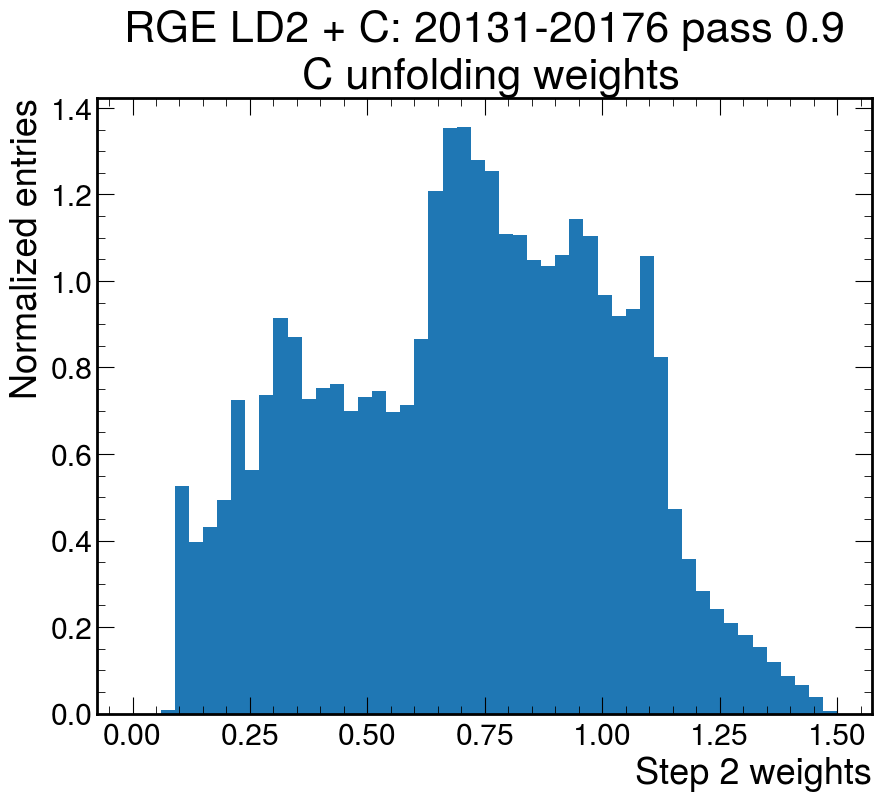

In [15]:
plt.figure(figsize=(10,8))
plt.hist(sim_dataframes["C"]["unfolded_weights"], bins=50, range=(0,1.5), density=True)
plt.title(plot_title+"\n C unfolding weights")
plt.xlabel("Step 2 weights")
plt.ylabel("Normalized entries")

Text(0, 1, 'Normalized entries')

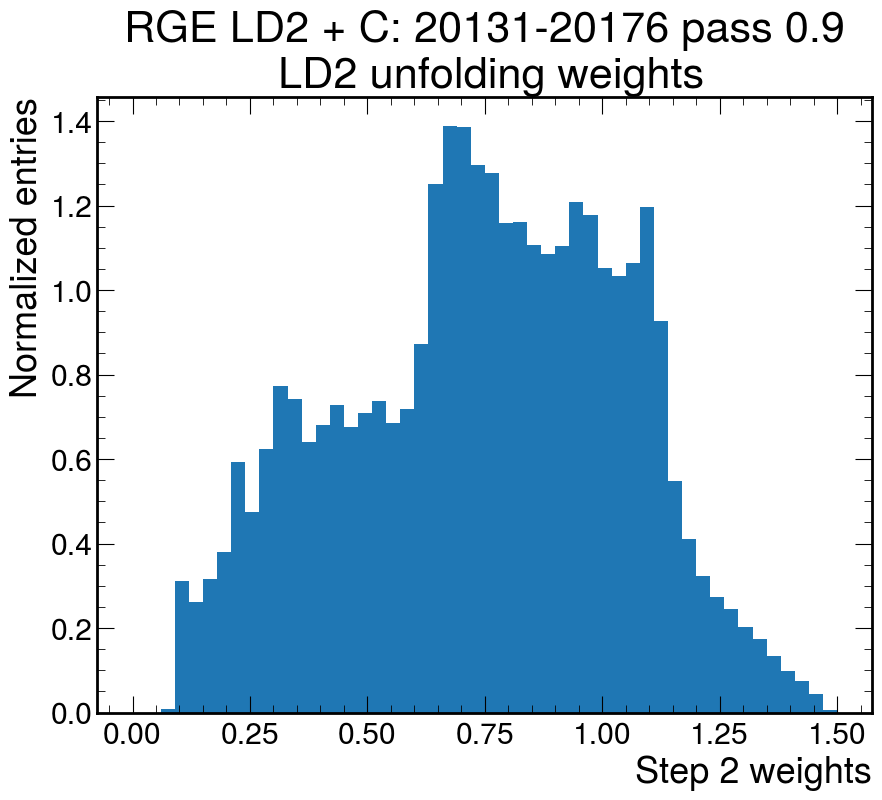

In [16]:
plt.figure(figsize=(10,8))
plt.hist(sim_dataframes["LD2"]["unfolded_weights"], bins=50, range=(0,1.5), density=True)
plt.title(plot_title+"\n LD2 unfolding weights")
plt.xlabel("Step 2 weights")
plt.ylabel("Normalized entries")

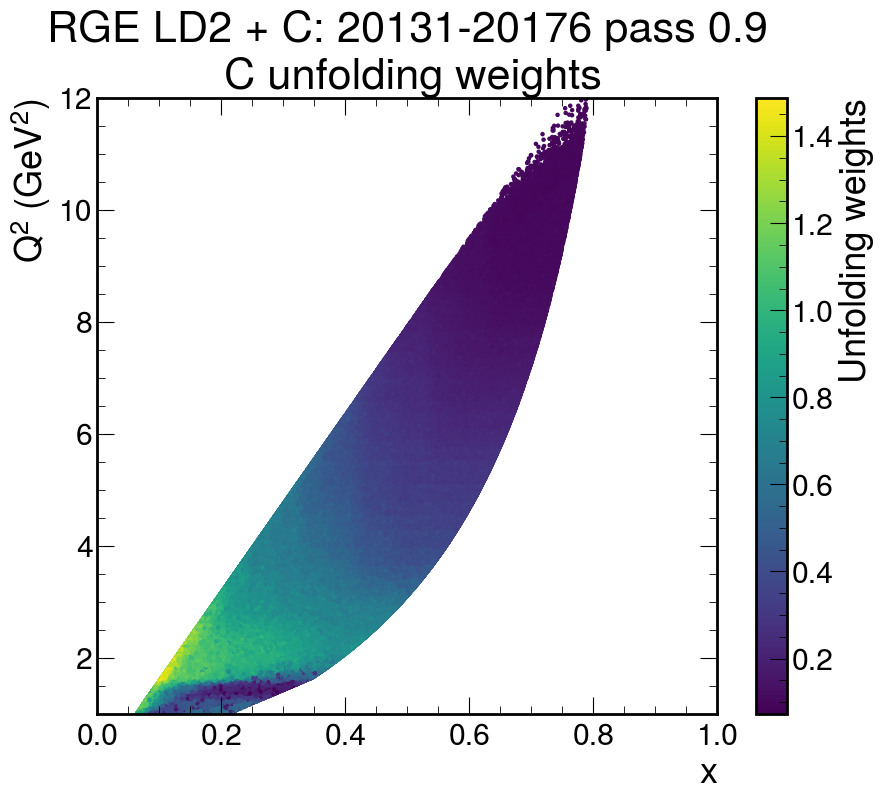

In [17]:
import matplotlib.pyplot as plt

df = sim_dataframes["C"]

x = df["MC_x"]
y = df["MC_Q2"]
w = df["unfolded_weights"]


plt.figure(figsize=(10,8))
sc = plt.scatter(x, y, c=w, s=5)   # small dots, default colormap

plt.xlabel("x")
plt.ylabel("$Q^2~(GeV^2)$")
plt.title(plot_title+"\n C unfolding weights")

cbar = plt.colorbar(sc)
cbar.set_label("Unfolding weights")
plt.ylim(1,12)
plt.xlim(0,1)
plt.show()


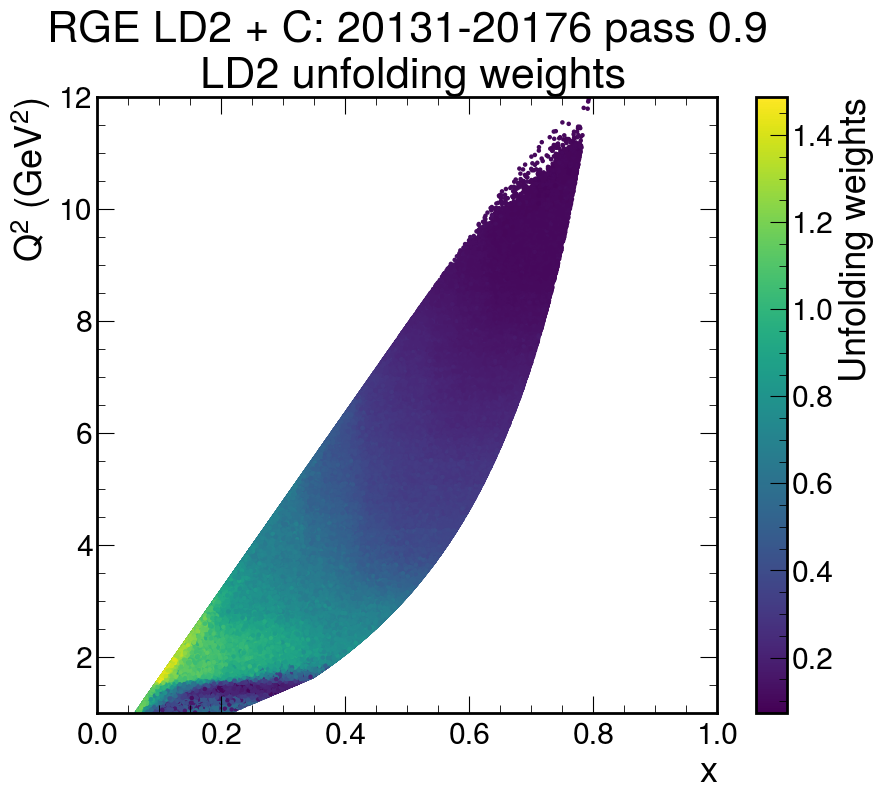

In [18]:
import matplotlib.pyplot as plt

df = sim_dataframes["LD2"]

x = df["MC_x"]
y = df["MC_Q2"]
w = df["unfolded_weights"]


plt.figure(figsize=(10,8))
sc = plt.scatter(x, y, c=w, s=5)   # small dots, default colormap

plt.xlabel("x")
plt.ylabel("$Q^2~(GeV^2)$")
plt.title(plot_title+"\n LD2 unfolding weights")
plt.ylim(1,12)
plt.xlim(0,1)
cbar = plt.colorbar(sc)
cbar.set_label("Unfolding weights")

plt.show()


### Getting radiative corrections from externals

In [19]:
def InputForExternals(x_bin_centers, Q2_bin_centers):
    Eb =  10.5473
    Mp = 0.938272
    x_bin_centers = np.asarray(x_bin_centers)
    Q2_bin_centers = np.asarray(Q2_bin_centers)
    Ep = Eb - Q2_bin_centers/(2. * Mp * x_bin_centers)
    theta = 2. * np.arcsin(np.sqrt(Q2_bin_centers/(4. * Eb * Ep)))
    
    theta_deg = np.degrees(theta)
    theta_deg[theta_deg<0] += 360
    print("E\tEp\ttheta\tW\ty\tx\tQ2")
    for Ep, theta in zip(Ep, theta_deg):
        if Ep < 0 or np.isnan(Ep) or np.isnan(theta):
            continue
        print("{Eb:.3f} {Ep:.3f} {theta:.4f}".format(Eb = round(Eb, 3), Ep = round(Ep, 3), theta = round(theta, 4)))
def CalculateCentroids(x_bin_edges, Q2_bin_edges, x_data, Q2_data):
    x_centroids = []
    Q2_centroids = []
    bin_yields = []
    for i, x_edge in enumerate(x_bin_edges):
        if i == len(x_bin_edges)-1:
            break
        x_bin_low, x_bin_high = x_edge, x_bin_edges[i+1]
        for j, Q2_edge in enumerate(Q2_bin_edges):
            if j == len(Q2_bin_edges)-1:
                break
            Q2_bin_low, Q2_bin_high = Q2_edge, Q2_bin_edges[j+1]
            bin_mask = (x_data < x_bin_high) & (x_data > x_bin_low) & (Q2_data < Q2_bin_high) & (Q2_data > Q2_bin_low)
            x_in_bin = x_data[bin_mask]
            Q2_in_bin = Q2_data[bin_mask]
            bin_yield = len(x_in_bin)
            if bin_yield != len(Q2_in_bin):
                print("wut")
            bin_yields.append(bin_yield)
            if len(x_in_bin) == 0 or len(Q2_in_bin) == 0:
                continue
            x_center = np.mean(x_in_bin)
            x_centroids.append(x_center)
            y_center = np.mean(Q2_in_bin)
            Q2_centroids.append(y_center)
    return x_centroids, Q2_centroids
def OpenCorrections(file):
    df = pd.read_csv(file, sep = '\s+')
    return df
def ApplyCorrections(Q2_bins, x_bins, counts, counts_errors, panda_df):
    counts_cc = np.copy(counts)
    counts_rc = np.copy(counts)
    counts_cc_rc = np.copy(counts)
    counts_cc_err = np.copy(counts_errors)
    counts_rc_err = np.copy(counts_errors)
    counts_cc_rc_err = np.copy(counts_errors)
    
    for _, row in panda_df.iterrows():
        Q2, x, cc, rc = row["Q2"], row["x"], row["C_cor"], row["Sig_Rad"]/row["Sig_Born"]
        Q2_bin_index, x_bin_index = np.digitize(Q2, Q2_bins), np.digitize(x, x_bins)

        if np.isnan(Q2) or np.isnan(x):
            continue
        if Q2_bin_index >= len(Q2_bins) or x_bin_index >= len(x_bins):
            continue
        counts_cc[x_bin_index-1][Q2_bin_index-1] *= cc
        counts_rc[x_bin_index-1][Q2_bin_index-1] /= rc
        counts_cc_rc[x_bin_index-1][Q2_bin_index-1] *= cc
        counts_cc_rc[x_bin_index-1][Q2_bin_index-1] /= rc

        counts_cc_err[x_bin_index-1][Q2_bin_index-1] *= cc
        counts_rc_err[x_bin_index-1][Q2_bin_index-1] /= rc
        counts_cc_rc_err[x_bin_index-1][Q2_bin_index-1] *= cc
        counts_cc_rc_err[x_bin_index-1][Q2_bin_index-1] /= rc
    print(counts_cc)
    return counts_cc, counts_rc, counts_cc_rc, counts_cc_err, counts_rc_err, counts_cc_rc_err


In [20]:
num_Q2_bins = 9*5
num_x_bins= 10*5
Q2_bin_edges = np.logspace(np.log10(1), np.log10(11), num=num_Q2_bins+1, base=10.)
x_bin_edges = np.linspace(0, .8, num=num_x_bins+1)
x_bin_centers = (x_bin_edges[:-1] + x_bin_edges[1:])/2
Q2_bin_centers = (Q2_bin_edges[:-1] + Q2_bin_edges[1:])/2
print("x bin centers: ", x_bin_centers)
print("Q2 bin centers: ", Q2_bin_centers)
# Values of the bin centers in 2d histogram format
x_padded, Q2_padded = np.meshgrid(x_bin_centers, Q2_bin_centers)
# Taking transpose gives x constant along inner dimension, Q2 varies along inner dimension
x_padded = x_padded.T
Q2_padded = Q2_padded.T

x bin centers:  [0.008 0.024 0.04  0.056 0.072 0.088 0.104 0.12  0.136 0.152 0.168 0.184
 0.2   0.216 0.232 0.248 0.264 0.28  0.296 0.312 0.328 0.344 0.36  0.376
 0.392 0.408 0.424 0.44  0.456 0.472 0.488 0.504 0.52  0.536 0.552 0.568
 0.584 0.6   0.616 0.632 0.648 0.664 0.68  0.696 0.712 0.728 0.744 0.76
 0.776 0.792]
Q2 bin centers:  [ 1.02736592  1.08359556  1.14290275  1.20545592  1.27143275  1.34102062
  1.41441715  1.49183082  1.57348147  1.65960102  1.75043405  1.84623854
  1.94728659  2.05386518  2.16627702  2.28484136  2.40989495  2.54179295
  2.68090998  2.82764113  2.98240316  3.14563559  3.31780204  3.49939147
  3.69091963  3.89293048  4.10599776  4.3307266   4.56775527  4.81775696
  5.0814417   5.35955839  5.65289692  5.96229041  6.28861758  6.63280524
  6.99583092  7.37872567  7.78257696  8.20853178  8.65779989  9.13165727
  9.63144974 10.15859678 10.71459555]


In [21]:
x_bin_centers_repeated = []
for xbins in x_padded:
    x_bin_centers_repeated.extend(xbins)
Q2_bin_centers_repeated = []
for Q2bins in Q2_padded:
    Q2_bin_centers_repeated.extend(Q2bins)
InputForExternals(x_bin_centers_repeated, Q2_bin_centers_repeated)

E	Ep	theta	W	y	x	Q2
10.547 0.771 20.4751
10.547 0.236 38.5391
10.547 2.943 10.4373
10.547 2.527 11.5717
10.547 2.088 13.0798
10.547 1.625 15.2383
10.547 1.137 18.7392
10.547 0.622 26.1306
10.547 0.079 81.4527
10.547 4.326 8.6056
10.547 3.985 9.2090
10.547 3.626 9.9167
10.547 3.248 10.7644
10.547 2.848 11.8086
10.547 2.427 13.1439
10.547 1.982 14.9454
10.547 1.513 17.5853
10.547 1.019 22.0599
10.547 0.497 32.6666
10.547 5.283 7.7858
10.547 4.995 8.2242
10.547 4.691 8.7164
10.547 4.371 9.2754
10.547 4.032 9.9187
10.547 3.676 10.6712
10.547 3.300 11.5700
10.547 2.903 12.6724
10.547 2.485 14.0744
10.547 2.044 15.9502
10.547 1.578 18.6629
10.547 1.087 23.1472
10.547 0.569 33.0823
10.547 5.985 7.3144
10.547 5.735 7.6742
10.547 5.472 8.0695
10.547 5.194 8.5069
10.547 4.901 8.9949
10.547 4.592 9.5448
10.547 4.266 10.1717
10.547 3.922 10.8966
10.547 3.560 11.7498
10.547 3.177 12.7768
10.547 2.774 14.0495
10.547 2.349 15.6911
10.547 1.900 17.9344
10.547 1.427 21.2912
10.547 0.927 27.2198
10.547 

/tmp/ipykernel_379487/1656089274.py:7: RuntimeWarning: invalid value encountered in sqrt
  theta = 2. * np.arcsin(np.sqrt(Q2_bin_centers/(4. * Eb * Ep)))
/tmp/ipykernel_379487/1656089274.py:7: RuntimeWarning: invalid value encountered in arcsin
  theta = 2. * np.arcsin(np.sqrt(Q2_bin_centers/(4. * Eb * Ep)))


In [22]:
initial_bin_dataframe = {"x_bin_center":x_bin_centers_repeated, "Q2_bin_center":Q2_bin_centers_repeated}
bin_dataframes = { solid_target:pd.DataFrame(initial_bin_dataframe.copy()), "LD2":pd.DataFrame(initial_bin_dataframe.copy())}

In [23]:
corrections_dict = {"C":OpenCorrections("/media/miguel/Elements_2024/CLAS_data/C/radiative_corrections/clasC12_geometric.out"), "LD2":OpenCorrections("/media/miguel/Elements_2024/CLAS_data/C/radiative_corrections/clasd2_geometric.out")}

In [24]:
corrections_dict["C"]["x_bin_center"] = x_bin_centers[np.digitize(corrections_dict["C"]["x"], x_bin_edges)-1]
corrections_dict["C"]["Q2_bin_center"] = Q2_bin_centers[np.digitize(corrections_dict["C"]["Q2"], Q2_bin_edges)-1]
corrections_dict["LD2"]["x_bin_center"] = x_bin_centers[np.digitize(corrections_dict["LD2"]["x"], x_bin_edges)-1]
corrections_dict["LD2"]["Q2_bin_center"] = Q2_bin_centers[np.digitize(corrections_dict["LD2"]["Q2"], Q2_bin_edges)-1]

In [25]:
merged_df = bin_dataframes["C"].merge(
    corrections_dict["C"][["x_bin_center", "Q2_bin_center", "C_cor", "Sig_Born", "Sig_Rad"]],
    on=["x_bin_center", "Q2_bin_center"],
    how="left"
)
bin_dataframes["C"] = merged_df

merged_df_deuterium = bin_dataframes["LD2"].merge(
    corrections_dict["LD2"][["x_bin_center", "Q2_bin_center", "C_cor", "Sig_Born", "Sig_Rad"]],
    on=["x_bin_center", "Q2_bin_center"],
    how="left"
)
bin_dataframes["LD2"] = merged_df_deuterium
bin_dataframes_nounfolding = bin_dataframes.copy()
bin_dataframes_reco = bin_dataframes.copy()

In [26]:
def DivideWithErrors(numerator, numerator_err, divisor, divisor_err):
    ratio = np.zeros_like(numerator)
    ratio_err = np.zeros_like(numerator)
    zero_mask = (numerator > 0) & (divisor > 0)
    ratio[zero_mask] = numerator[zero_mask] / divisor[zero_mask]
    ratio_err[zero_mask] = ratio[zero_mask] * np.sqrt( ( numerator_err[zero_mask]/numerator[zero_mask] )**2 + ( divisor_err[zero_mask]/divisor[zero_mask] )**2)
    ratio[~zero_mask] = None
    ratio_err[~zero_mask] = None
    return ratio, ratio_err

In [27]:
def normalize_2dhist_and_errors(x_edges, y_edges, nonnormalized_hist, nonnormalized_errors):
    x_widths = np.diff(x_edges)
    y_widths = np.diff(y_edges)
    bin_areas = np.outer(x_widths, y_widths)
    total_counts = np.sum(nonnormalized_hist)
    normalized_counts = nonnormalized_hist / (total_counts * bin_areas)
    normalized_errors = nonnormalized_errors / (total_counts * bin_areas)
    return normalized_counts, normalized_errors
def normalize_to_absolute_cross_section(x_edges, y_edges, nonnormalized_hist, nonnormalized_errors, target, integrated_luminosity):
    x_widths = np.diff(x_edges)
    y_widths = np.diff(y_edges)
    bin_areas = np.outer(x_widths, y_widths)
    normalized_counts = (nonnormalized_hist*cm_to_pb) / (integrated_luminosity * bin_areas)
    normalized_errors = (nonnormalized_errors*cm_to_pb) / (integrated_luminosity * bin_areas)
    return normalized_counts, normalized_errors

In [28]:
def GetCorrections(Q2_bins, x_bins, panda_df):
    
    for _, row in panda_df.iterrows():
        Q2, x, cc, rc = row["Q2"], row["x"], row["C_cor"], row["Sig_Rad"]/row["Sig_Born"]

    
        Q2_bin_index, x_bin_index = np.digitize(Q2, Q2_bins), np.digitize(x, x_bins)

        if np.isnan(Q2) or np.isnan(x):
            continue
        if Q2_bin_index >= len(Q2_bins) or x_bin_index >= len(x_bins):
            continue
        counts_cc_rc_err[x_bin_index-1][Q2_bin_index-1] /= rc
    print(counts_cc)
    return counts_cc, counts_rc, counts_cc_rc, counts_cc_err, counts_rc_err, counts_cc_rc_err


C
[[  0.       0.       0.     ...   0.       0.       0.    ]
 [  0.       0.       0.     ...   0.       0.       0.    ]
 [  0.       0.       0.     ...   0.       0.       0.    ]
 ...
 [  0.       0.       0.     ... 190.3797 770.0356 860.3358]
 [  0.       0.       0.     ...   0.      13.104  338.9232]
 [  0.       0.       0.     ...   0.       0.       0.    ]]
LD2
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  95. 337. 372.]
 [  0.   0.   0. ...   0.   2. 174.]
 [  0.   0.   0. ...   0.   0.   0.]]


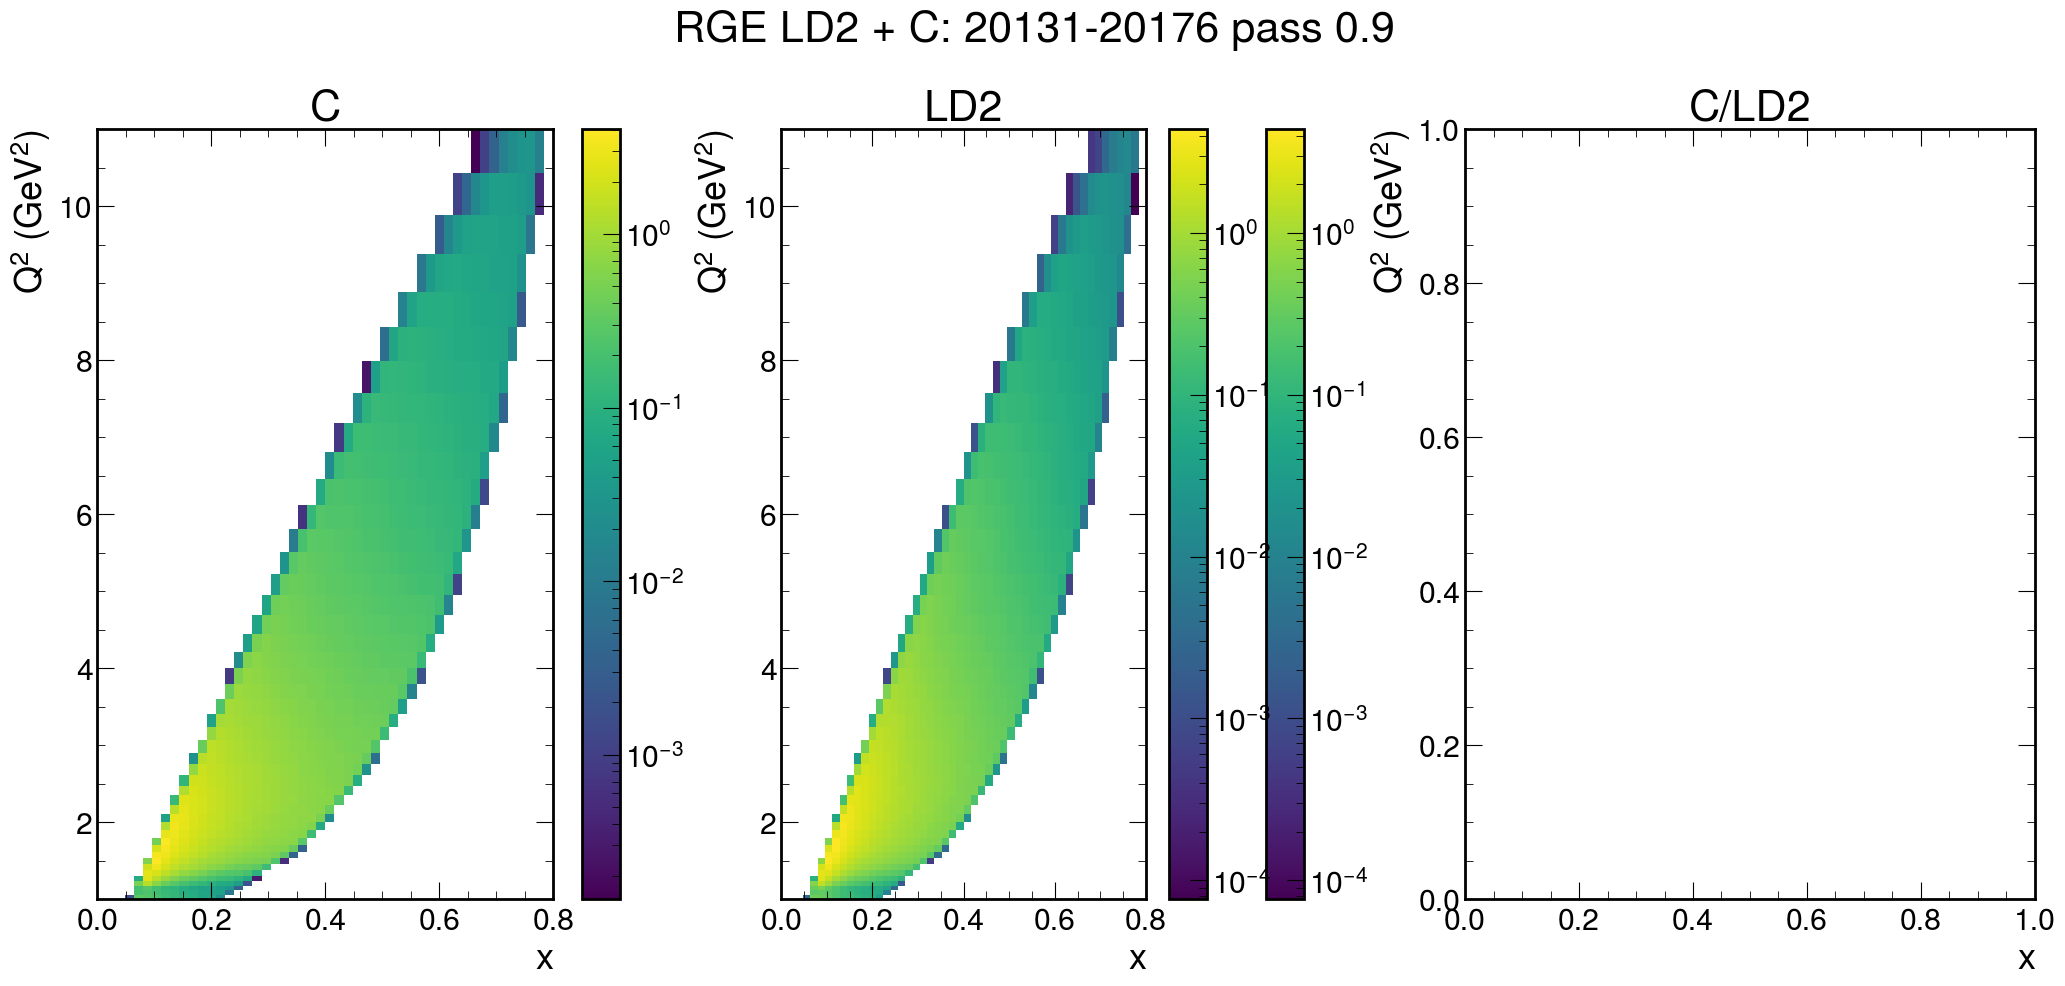

In [29]:
normalized_cross_sections, normalized_cross_sections_errors = {}, {}
fig, axs = plt.subplots(1,3, figsize=(25,10))

for i, (target_name, target_data) in enumerate(sim_dataframes.items()):
    print(target_name)
    bin_counts_df = pd.DataFrame({
        "x_bin_center": np.repeat(x_bin_centers, len(Q2_bin_centers)),
        "Q2_bin_center": np.tile(Q2_bin_centers, len(x_bin_centers)),
    })
    plt.sca(axs[i])
    
    nonnormalized_cross_sections, _, _ = np.histogram2d(
        target_data.MC_x,
        target_data.MC_Q2,
        bins=(x_bin_edges, Q2_bin_edges),
    )
    nonnormalized_cross_sections_errors = np.sqrt(nonnormalized_cross_sections)

    bin_counts_df["nonnormalized_cross_sections"] = nonnormalized_cross_sections.flatten()
    bin_counts_df["nonnormalized_cross_sections_errors"] = nonnormalized_cross_sections_errors.flatten()

    corrections_df = corrections_dict[target_name]

    # Calculating histograms with CC, RC, and RC*CC
    cc, rc, rc_cc, cc_err, rc_err, rc_cc_err = ApplyCorrections(
        Q2_bin_edges,
        x_bin_edges,
        nonnormalized_cross_sections,
        nonnormalized_cross_sections_errors,
        corrections_df
    )
    
    absolute_cross_sections, absolute_cross_sections_errors = normalize_to_absolute_cross_section(
        x_bin_edges,
        Q2_bin_edges,
        rc_cc,
        rc_cc_err,
        target_name,
        integrated_luminosity
    )

    bin_counts_df["absolute_cross_sections"] = absolute_cross_sections.flatten()
    bin_counts_df["absolute_cross_sections_errors"] = absolute_cross_sections_errors.flatten()

    merged_df = bin_dataframes_nounfolding[target_name].merge(
        bin_counts_df,
        on=["x_bin_center", "Q2_bin_center"],
        how="left"
    )
    bin_dataframes_nounfolding[target_name] = merged_df

    plt.hist2d(
        target_data.MC_x,
        target_data.MC_Q2,
        bins=(x_bin_edges, Q2_bin_edges),
        norm = mcolors.LogNorm(),
        density=True
    )

    plt.xlabel("x")
    plt.ylabel("$Q^2~ (GeV^2)$")
    plt.title(target_name)
    plt.colorbar()

plt.sca(axs[2])
# ratio_hist, ratio_hist_err = DivideWithErrors(
#     numerator = normalized_cross_sections[solid_target],
#     numerator_err = normalized_cross_sections_errors[solid_target],
#     divisor = normalized_cross_sections["LD2"],
#     divisor_err = normalized_cross_sections_errors["LD2"]
# )
# plt.hist2d(
#     np.ravel(x_padded),
#     np.ravel(Q2_padded),
#     weights=np.ravel(ratio_hist),
#     bins=(x_bin_edges, Q2_bin_edges),
#     norm=mcolors.Normalize(0.5, 1.5), cmap=colormaps['bwr']
# )

plt.xlabel("x")
plt.ylabel("$Q^2~ (GeV^2)$")  
plt.title(f"{solid_target}/LD2")
plt.suptitle(plot_title, y=1.)
plt.colorbar()
plt.show()

C
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 20.16314707 80.92423829
  86.60318342]
 [ 0.          0.          0.         ...  0.          1.3741657
  34.20358132]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
LD2
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 10.05862377 35.42642298
  37.52485587]
 [ 0.          0.          0.         ...  0.          0.20828313
  17.41772881]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


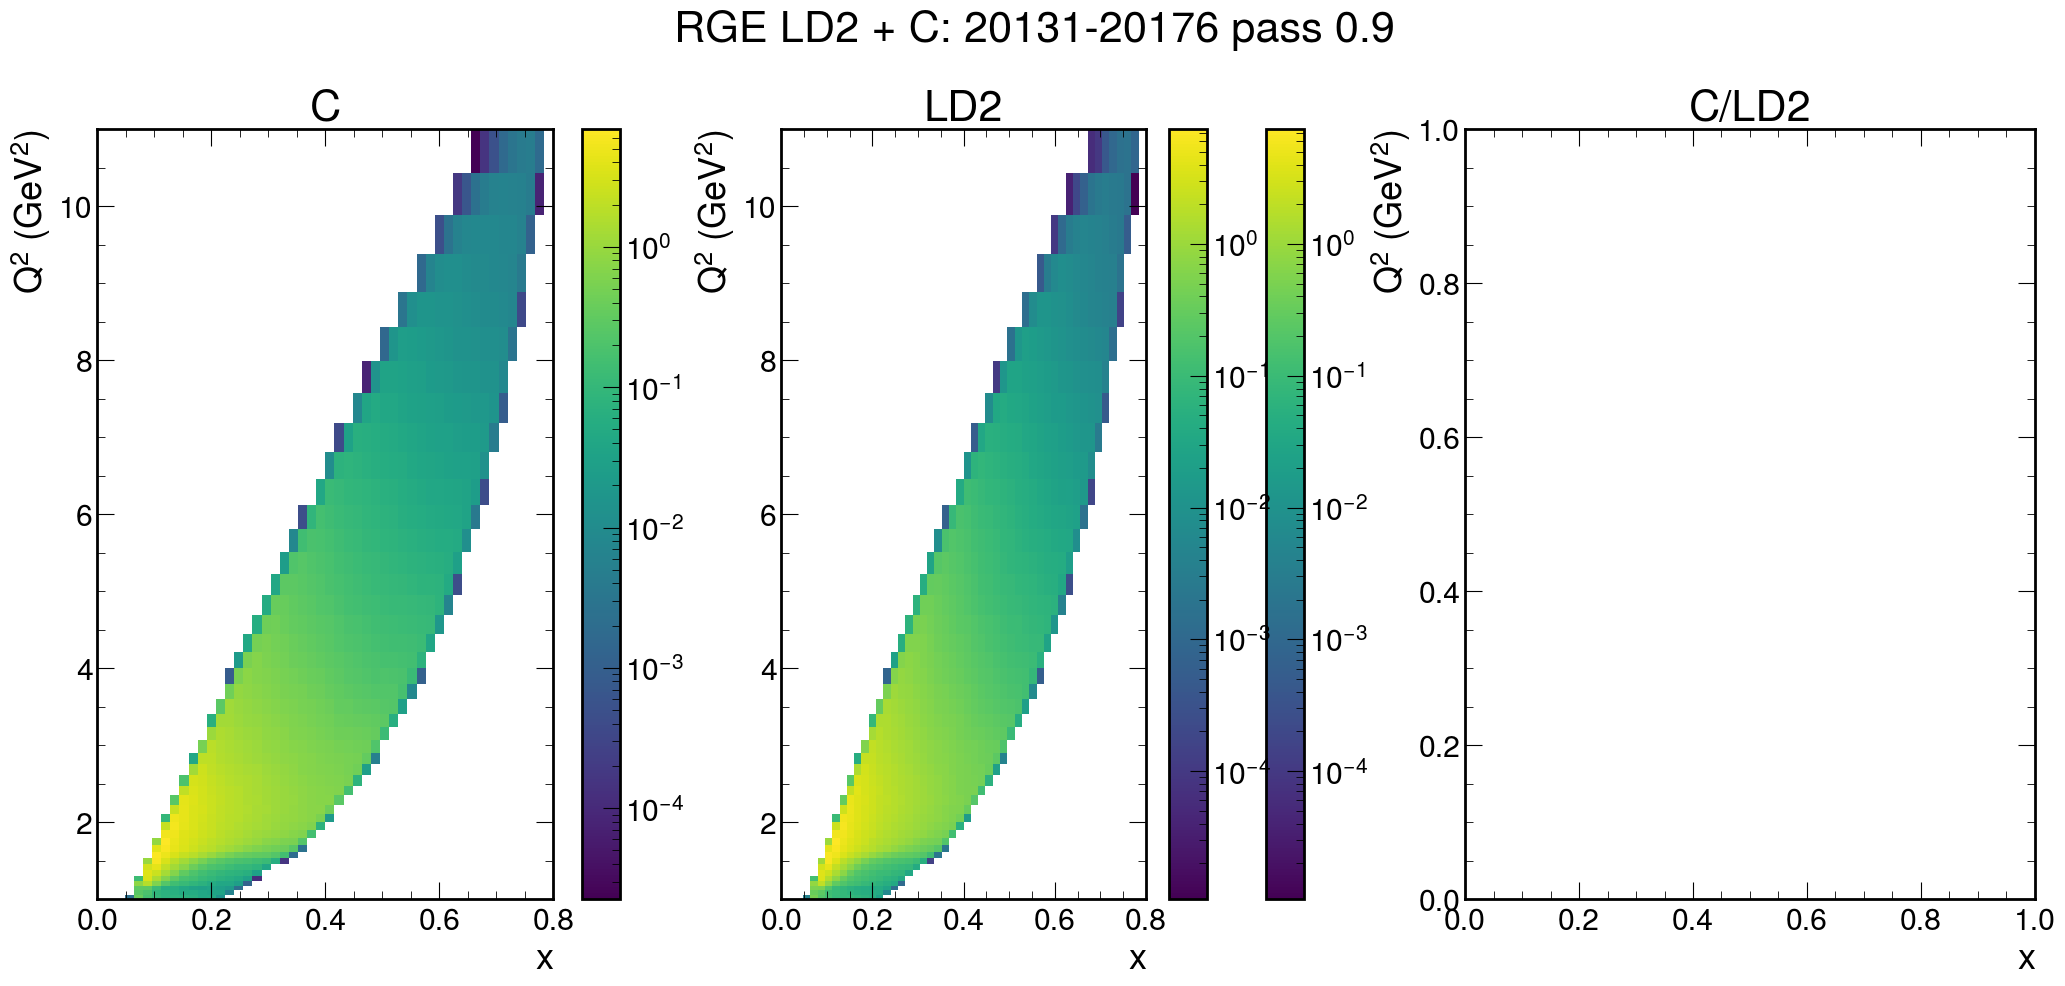

In [30]:
normalized_cross_sections, normalized_cross_sections_errors = {}, {}
fig, axs = plt.subplots(1,3, figsize=(25,10))

for i, (target_name, target_data) in enumerate(sim_dataframes.items()):
    print(target_name)
    bin_counts_df = pd.DataFrame({
        "x_bin_center": np.repeat(x_bin_centers, len(Q2_bin_centers)),
        "Q2_bin_center": np.tile(Q2_bin_centers, len(x_bin_centers)),
    })
    plt.sca(axs[i])
    
    nonnormalized_cross_sections, _, _ = np.histogram2d(
        target_data.MC_x,
        target_data.MC_Q2,
        bins=(x_bin_edges, Q2_bin_edges),
        weights = target_data.unfolded_weights*target_data.weight,
    )
    nonnormalized_cross_sections_errors = np.sqrt(nonnormalized_cross_sections)

    bin_counts_df["nonnormalized_cross_sections"] = nonnormalized_cross_sections.flatten()
    bin_counts_df["nonnormalized_cross_sections_errors"] = nonnormalized_cross_sections_errors.flatten()

    corrections_df = corrections_dict[target_name]

    # Calculating histograms with CC, RC, and RC*CC
    cc, rc, rc_cc, cc_err, rc_err, rc_cc_err = ApplyCorrections(
        Q2_bin_edges,
        x_bin_edges,
        nonnormalized_cross_sections,
        nonnormalized_cross_sections_errors,
        corrections_df
    )
    
    absolute_cross_sections, absolute_cross_sections_errors = normalize_to_absolute_cross_section(
        x_bin_edges,
        Q2_bin_edges,
        rc_cc,
        rc_cc_err,
        target_name,
        integrated_luminosity
    )

    bin_counts_df["absolute_cross_sections"] = absolute_cross_sections.flatten()
    bin_counts_df["absolute_cross_sections_errors"] = absolute_cross_sections_errors.flatten()

    merged_df = bin_dataframes[target_name].merge(
        bin_counts_df,
        on=["x_bin_center", "Q2_bin_center"],
        how="left"
    )
    bin_dataframes[target_name] = merged_df

    plt.hist2d(
        target_data.MC_x,
        target_data.MC_Q2,
        bins=(x_bin_edges, Q2_bin_edges),
        norm = mcolors.LogNorm(),
        weights = target_data.unfolded_weights,
        density=True
    )

    plt.xlabel("x")
    plt.ylabel("$Q^2~ (GeV^2)$")
    plt.title(target_name)
    plt.colorbar()

plt.sca(axs[2])
# ratio_hist, ratio_hist_err = DivideWithErrors(
#     numerator = normalized_cross_sections[solid_target],
#     numerator_err = normalized_cross_sections_errors[solid_target],
#     divisor = normalized_cross_sections["LD2"],
#     divisor_err = normalized_cross_sections_errors["LD2"]
# )
# plt.hist2d(
#     np.ravel(x_padded),
#     np.ravel(Q2_padded),
#     weights=np.ravel(ratio_hist),
#     bins=(x_bin_edges, Q2_bin_edges),
#     norm=mcolors.Normalize(0.5, 1.5), cmap=colormaps['bwr']
# )

plt.xlabel("x")
plt.ylabel("$Q^2~ (GeV^2)$")  
plt.title(f"{solid_target}/LD2")
plt.suptitle(plot_title, y=1.)
plt.colorbar()
plt.show()

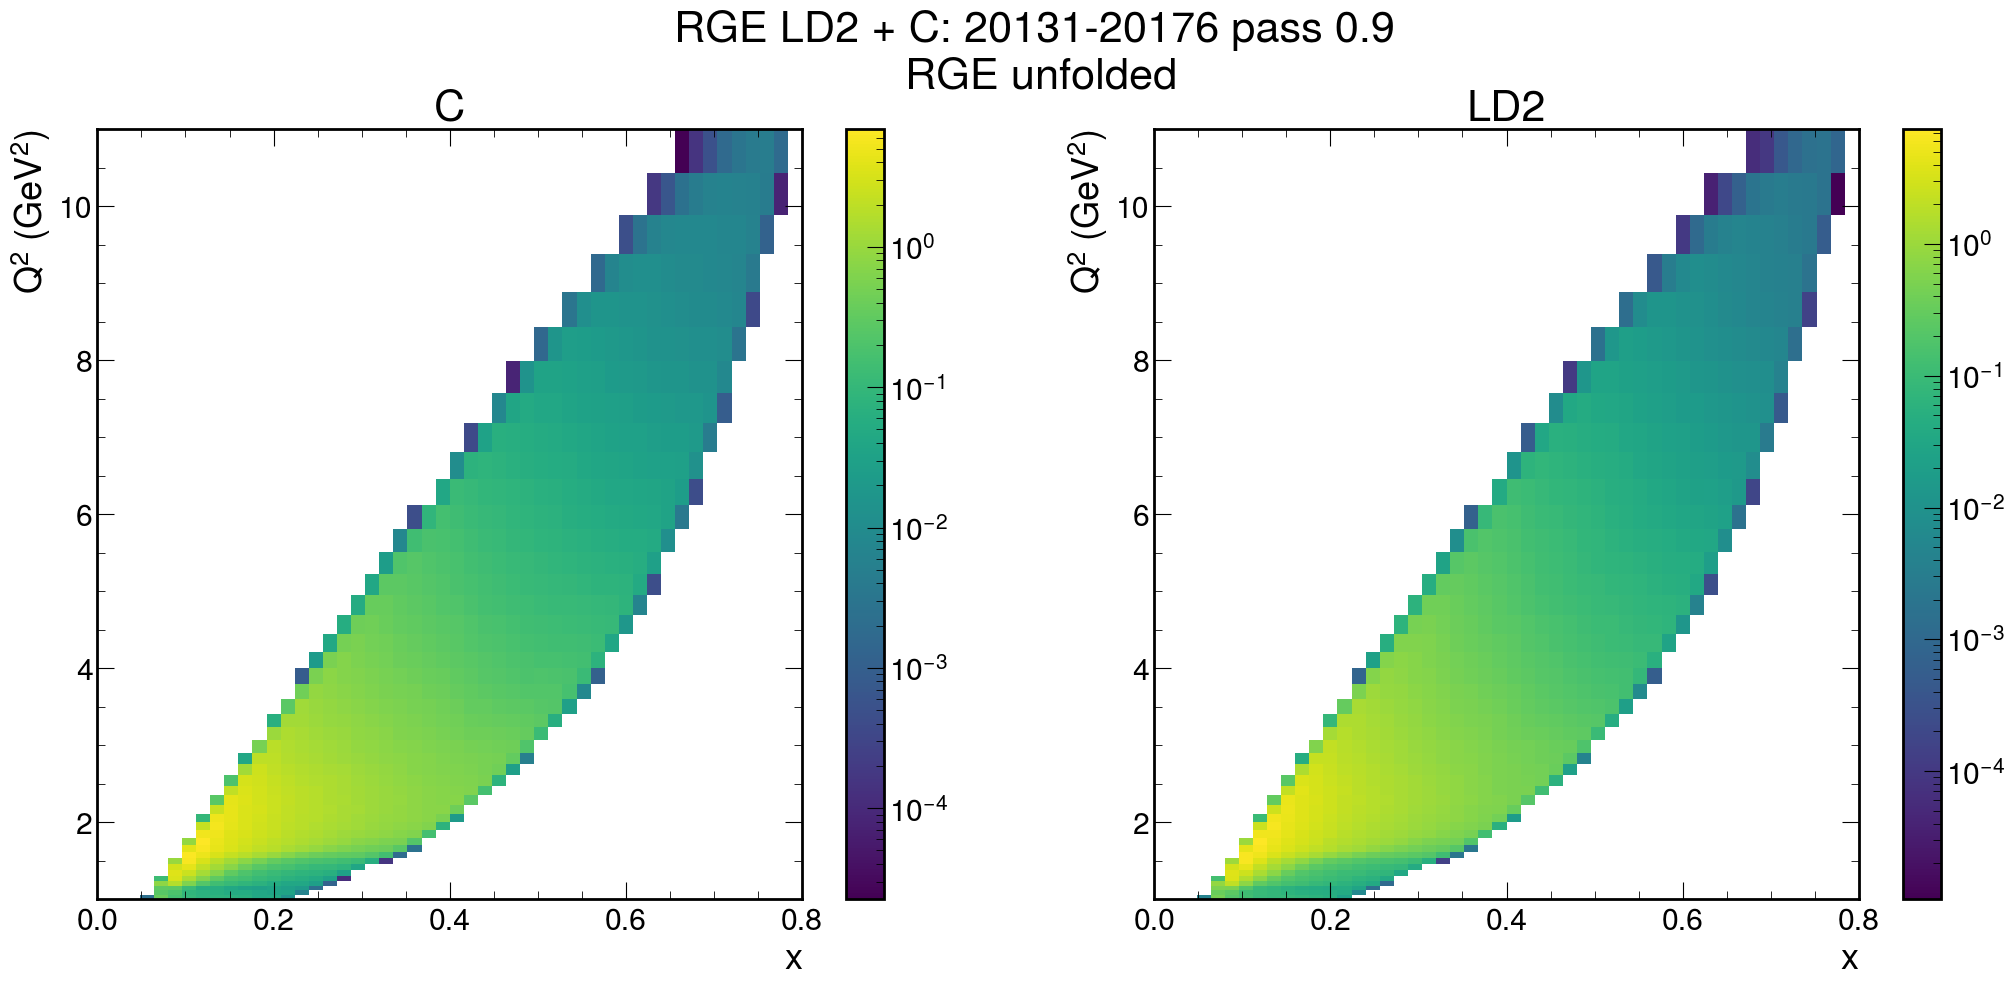

In [31]:
fig, axs = plt.subplots(1,2, figsize=(25,10))

for i, (target_name, target_data) in enumerate(sim_dataframes.items()):
    plt.sca(axs[i])
    
    
    plt.hist2d(
        target_data.MC_x,
        target_data.MC_Q2,
        bins=(x_bin_edges, Q2_bin_edges),
        norm = mcolors.LogNorm(),
        density=True,
        weights = target_data.unfolded_weights,
        
    )

    plt.xlabel("x")
    plt.ylabel("$Q^2~ (GeV^2)$")
    plt.title(target_name)
    plt.colorbar()

plt.xlabel("x")
plt.ylabel("$Q^2~ (GeV^2)$")  
plt.suptitle(plot_title + "\n RGE unfolded", y=1.)
plt.show()

C
[[ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 ...
 [ 0.      0.      0.     ... 11.0803 22.1738 20.172 ]
 [ 0.      0.      0.     ...  0.      0.      6.0522]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]
LD2
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 15. 27. 21.]
 [ 0.  0.  0. ...  0.  0.  9.]
 [ 0.  0.  0. ...  0.  0.  0.]]


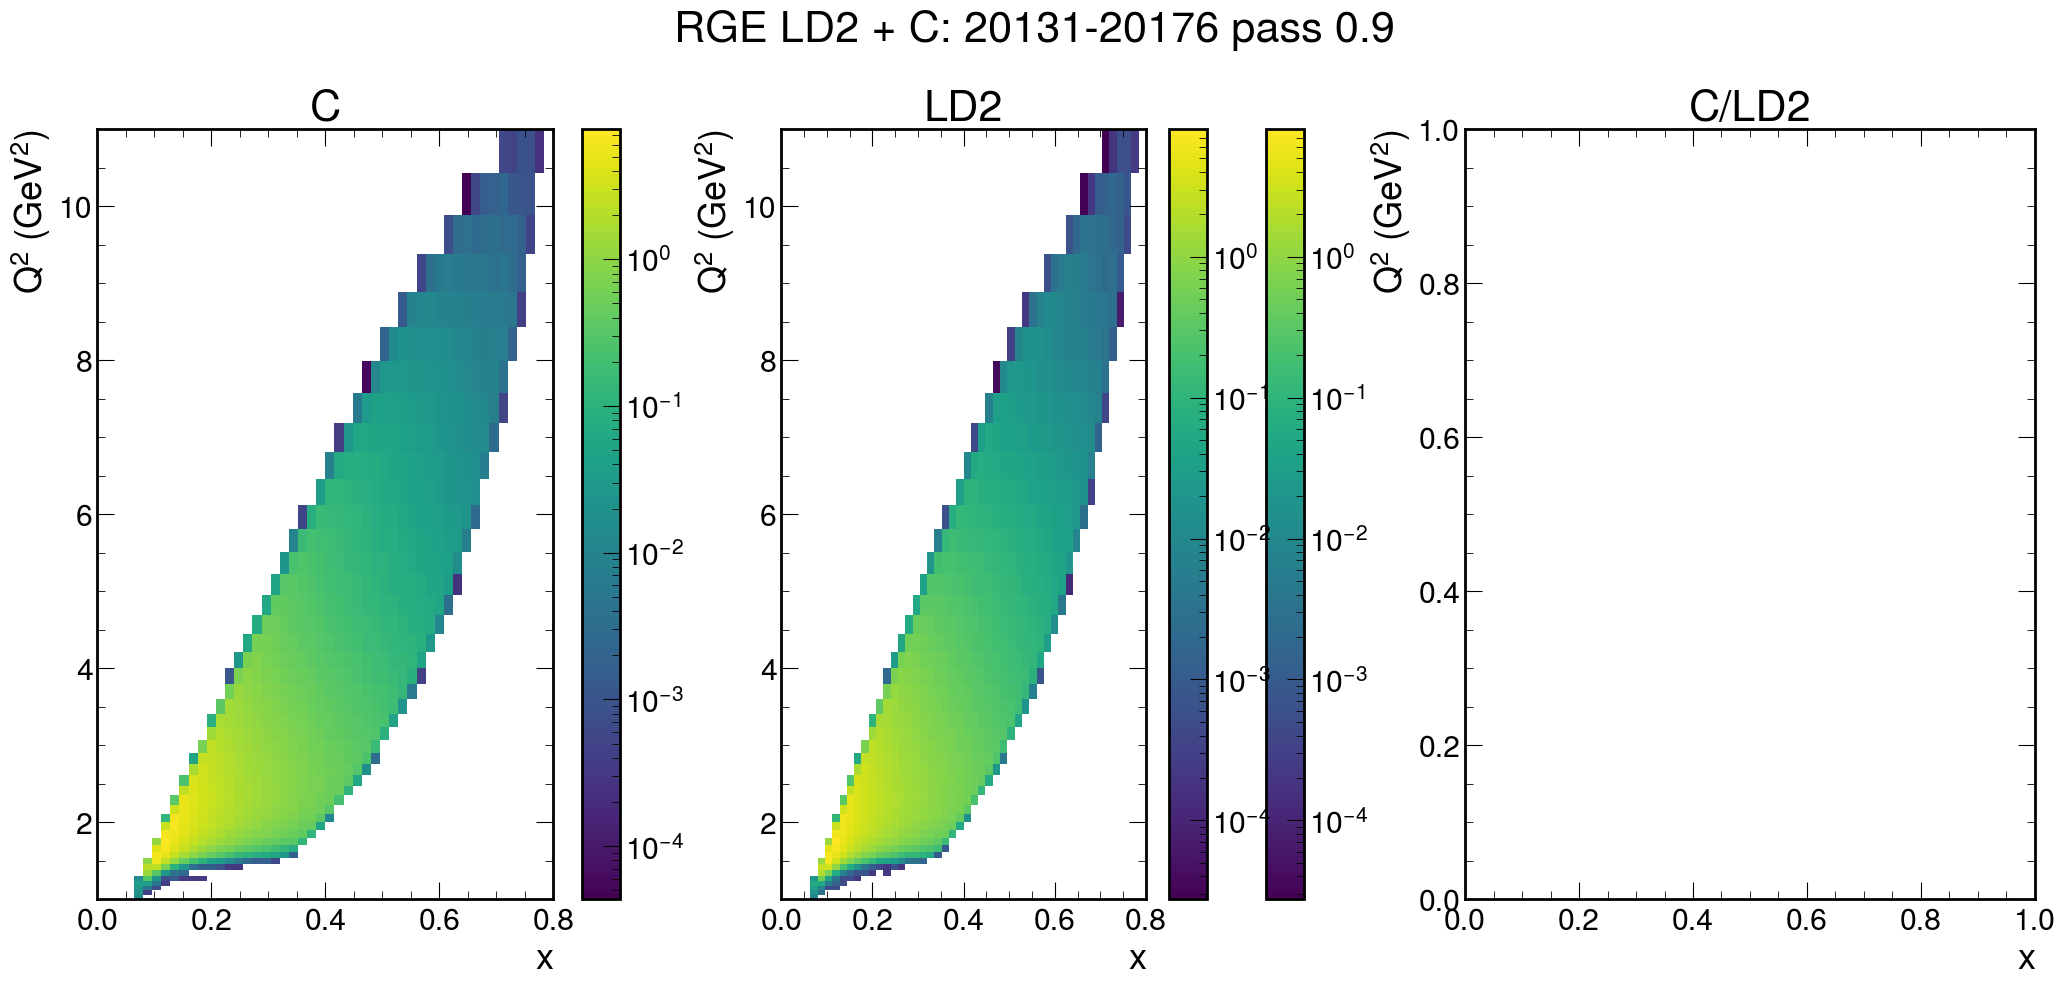

In [32]:
normalized_cross_sections, normalized_cross_sections_errors = {}, {}
fig, axs = plt.subplots(1,3, figsize=(25,10))

for i, (target_name, target_data) in enumerate(dataframes.items()):
    print(target_name)
    bin_counts_reco_df = pd.DataFrame({
        "x_bin_center": np.repeat(x_bin_centers, len(Q2_bin_centers)),
        "Q2_bin_center": np.tile(Q2_bin_centers, len(x_bin_centers)),
    })
    plt.sca(axs[i])
    
    nonnormalized_cross_sections, _, _ = np.histogram2d(
        target_data.x,
        target_data.Q2,
        bins=(x_bin_edges, Q2_bin_edges),
    )
    nonnormalized_cross_sections_errors = np.sqrt(nonnormalized_cross_sections)

    bin_counts_reco_df["nonnormalized_cross_sections"] = nonnormalized_cross_sections.flatten()
    bin_counts_reco_df["nonnormalized_cross_sections_errors"] = nonnormalized_cross_sections_errors.flatten()

    corrections_df = corrections_dict[target_name]

    # Calculating histograms with CC, RC, and RC*CC
    cc, rc, rc_cc, cc_err, rc_err, rc_cc_err = ApplyCorrections(
        Q2_bin_edges,
        x_bin_edges,
        nonnormalized_cross_sections,
        nonnormalized_cross_sections_errors,
        corrections_df
    )
    
    absolute_cross_sections, absolute_cross_sections_errors = normalize_to_absolute_cross_section(
        x_bin_edges,
        Q2_bin_edges,
        rc_cc,
        rc_cc_err,
        target_name,
        integrated_luminosity_reco
    )

    bin_counts_reco_df["absolute_cross_sections"] = absolute_cross_sections.flatten()
    bin_counts_reco_df["absolute_cross_sections_errors"] = absolute_cross_sections_errors.flatten()

    merged_df = bin_dataframes_reco[target_name].merge(
        bin_counts_reco_df,
        on=["x_bin_center", "Q2_bin_center"],
        how="left"
    )
    bin_dataframes_reco[target_name] = merged_df

    plt.hist2d(
        target_data.x,
        target_data.Q2,
        bins=(x_bin_edges, Q2_bin_edges),
        norm = mcolors.LogNorm(),
        density=True
    )

    plt.xlabel("x")
    plt.ylabel("$Q^2~ (GeV^2)$")
    plt.title(target_name)
    plt.colorbar()

plt.sca(axs[2])
# ratio_hist, ratio_hist_err = DivideWithErrors(
#     numerator = normalized_cross_sections[solid_target],
#     numerator_err = normalized_cross_sections_errors[solid_target],
#     divisor = normalized_cross_sections["LD2"],
#     divisor_err = normalized_cross_sections_errors["LD2"]
# )
# plt.hist2d(
#     np.ravel(x_padded),
#     np.ravel(Q2_padded),
#     weights=np.ravel(ratio_hist),
#     bins=(x_bin_edges, Q2_bin_edges),
#     norm=mcolors.Normalize(0.5, 1.5), cmap=colormaps['bwr']
# )

plt.xlabel("x")
plt.ylabel("$Q^2~ (GeV^2)$")  
plt.title(f"{solid_target}/LD2")
plt.suptitle(plot_title, y=1.)
plt.colorbar()
plt.show()

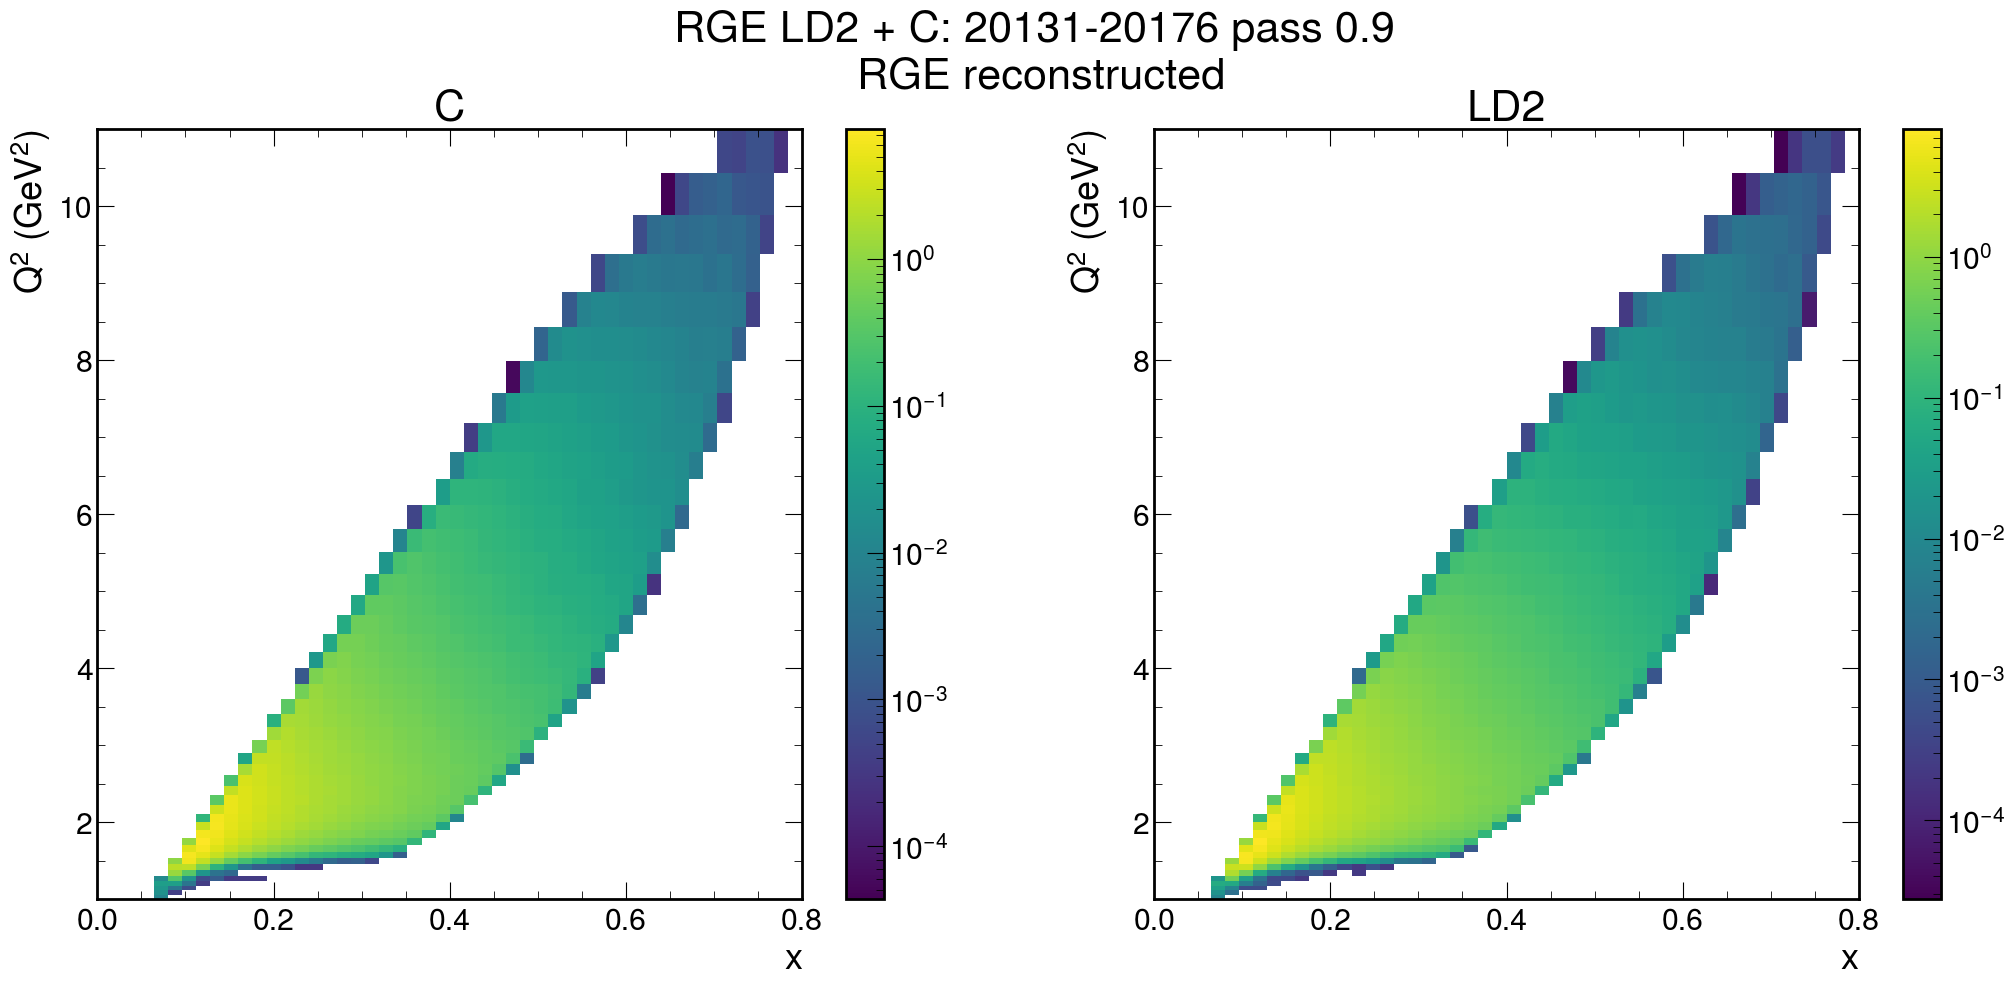

In [33]:
fig, axs = plt.subplots(1,2, figsize=(25,10))

for i, (target_name, target_data) in enumerate(dataframes.items()):
    plt.sca(axs[i])
    
    
    plt.hist2d(
        target_data.x,
        target_data.Q2,
        bins=(x_bin_edges, Q2_bin_edges),
        norm = mcolors.LogNorm(),
        density=True,
        
    )

    plt.xlabel("x")
    plt.ylabel("$Q^2~ (GeV^2)$")
    plt.title(target_name )
    plt.colorbar()

plt.xlabel("x")
plt.ylabel("$Q^2~ (GeV^2)$")  
plt.suptitle(plot_title+ "\n RGE reconstructed", y=1.)
plt.show()

In [34]:
Q2_binning = np.arange(1, 12, 1)
plot_colors = list(plt.rcParams["axes.prop_cycle"])
plot_labels = []
plot_labels_used = []
for i in range(len(Q2_binning)-1):
    plot_labels.append(f"{Q2_binning[i]} < $Q^2$ < {Q2_binning[i+1]}")
    plot_labels_used.append(False)

In [35]:
def calc_theta_lab(px, py, pz):
    return np.arctan2(np.sqrt(px**2 + py**2), pz)
def calc_Q2(p, beam_E, theta):
    return 4 * p * beam_E* np.sin(theta/2)*np.sin(theta/2)
def calc_nu(p, beam_E):
    return beam_E - p
def calc_xb(Q2, beam_E, nu):
    proton_mass = .938
    return np.array(Q2/(2*proton_mass*nu))
def calc_y(p, beam_E):
    return calc_nu(p, beam_E)/beam_E
def calc_W2(p, beam_E, theta):
    proton_mass = .938
    return proton_mass*proton_mass + 2*proton_mass*calc_nu(p, beam_E) - calc_Q2(p, beam_E, theta)

In [36]:
def Q2_calculation_from_y(y_val, x_values):
    Eb = 10.547
    Mp = 0.938272
    return 2*Mp*Eb*y_val*np.asarray(x_values)
def y_calculation_from_Q2_x(x_values, Q2_values):
    Eb = 10.547
    Mp = 0.938272
    return np.asarray(Q2_values)/(np.asarray(x_values)*2*Mp*Eb)
Eb =  10.5473
Mp = 0.938272

(0.0, 1.25)

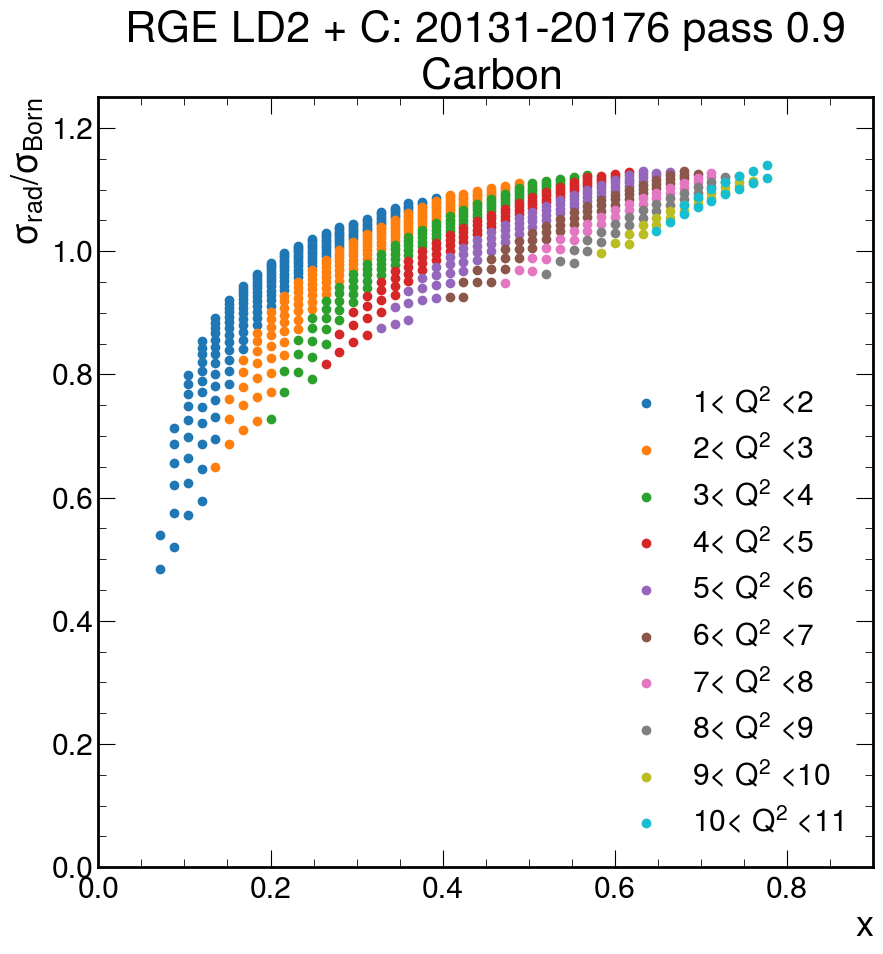

In [37]:
for i, Q2_lower_edge in enumerate(Q2_binning):
    if i == len(Q2_binning)-1:
        continue
    Q2_range = (Q2_lower_edge, Q2_binning[i+1])
    
    corrections = bin_dataframes["C"].query(f"Q2_bin_center>{Q2_range[0]} & Q2_bin_center<{Q2_range[1]} & nonnormalized_cross_sections>0")
    
    y = y_calculation_from_Q2_x(corrections["x_bin_center"], corrections["Q2_bin_center"])
    y_mask = y < .8
    plt.scatter(corrections["x_bin_center"][y_mask], corrections["Sig_Born"][y_mask]/corrections["Sig_Rad"][y_mask], label=f"{round(Q2_range[0],2)}< $Q^2$ <{round(Q2_range[1],2)}")
    # plt.scatter(corrections["x_bin_center"], corrections["Sig_Born"]/corrections["Sig_Rad"], label=f"{round(Q2_range[0],2)}< $Q^2$ <{round(Q2_range[1],2)}")
plt.legend()
plt.xlabel("x")
plt.ylabel("$\sigma_{rad}/\sigma_{Born}$")
plt.title(plot_title+"\n Carbon")
plt.xlim(0, .9)
plt.ylim(0, 1.25)

(0.99, 1.01)

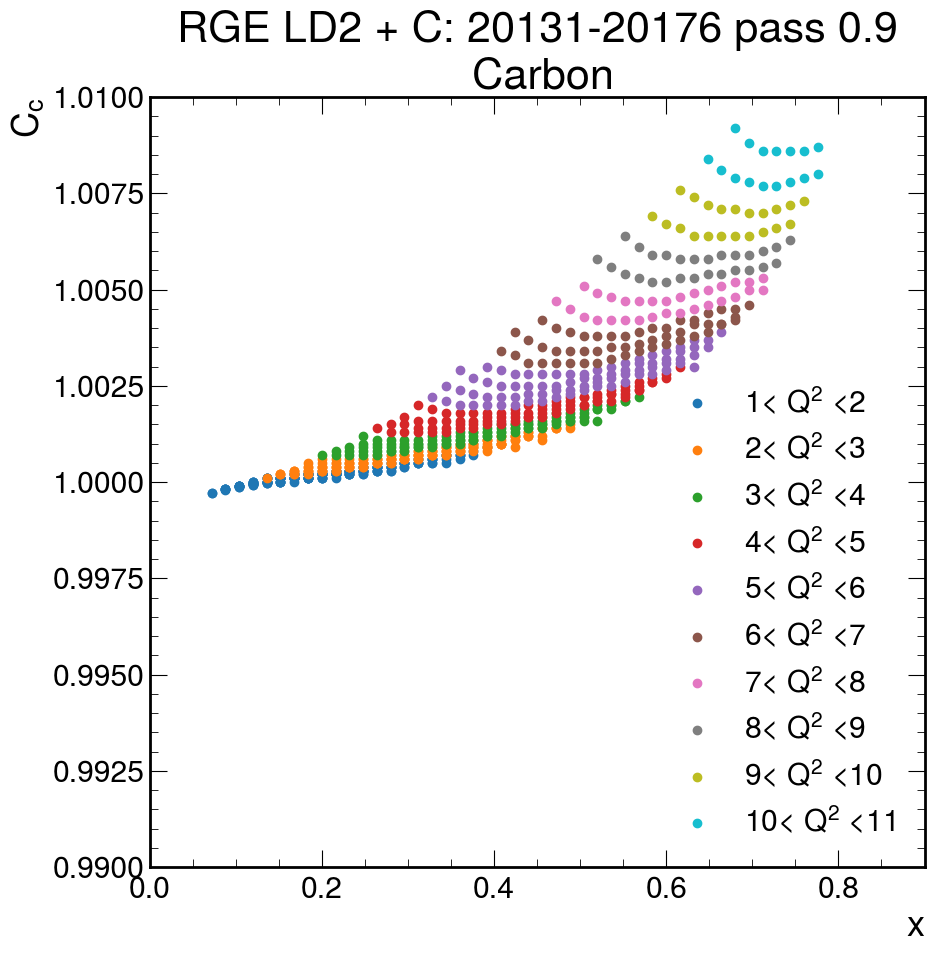

In [38]:
for i, Q2_lower_edge in enumerate(Q2_binning):
    if i == len(Q2_binning)-1:
        continue
    Q2_range = (Q2_lower_edge, Q2_binning[i+1])
    
    corrections = bin_dataframes["C"].query(f"Q2_bin_center>{Q2_range[0]} & Q2_bin_center<{Q2_range[1]} and nonnormalized_cross_sections>0 ")
    
    y = y_calculation_from_Q2_x(corrections["x_bin_center"], corrections["Q2_bin_center"])
    y_mask = y < .8
    plt.scatter(corrections["x_bin_center"][y_mask], corrections["C_cor"][y_mask], label=f"{round(Q2_range[0],2)}< $Q^2$ <{round(Q2_range[1],2)}")
plt.legend()
plt.xlabel("x")
plt.ylabel("$C_{c}$")
plt.title(plot_title+"\n Carbon")
plt.xlim(0, .9)
plt.ylim(.99, 1.01)

(0.0, 1.2)

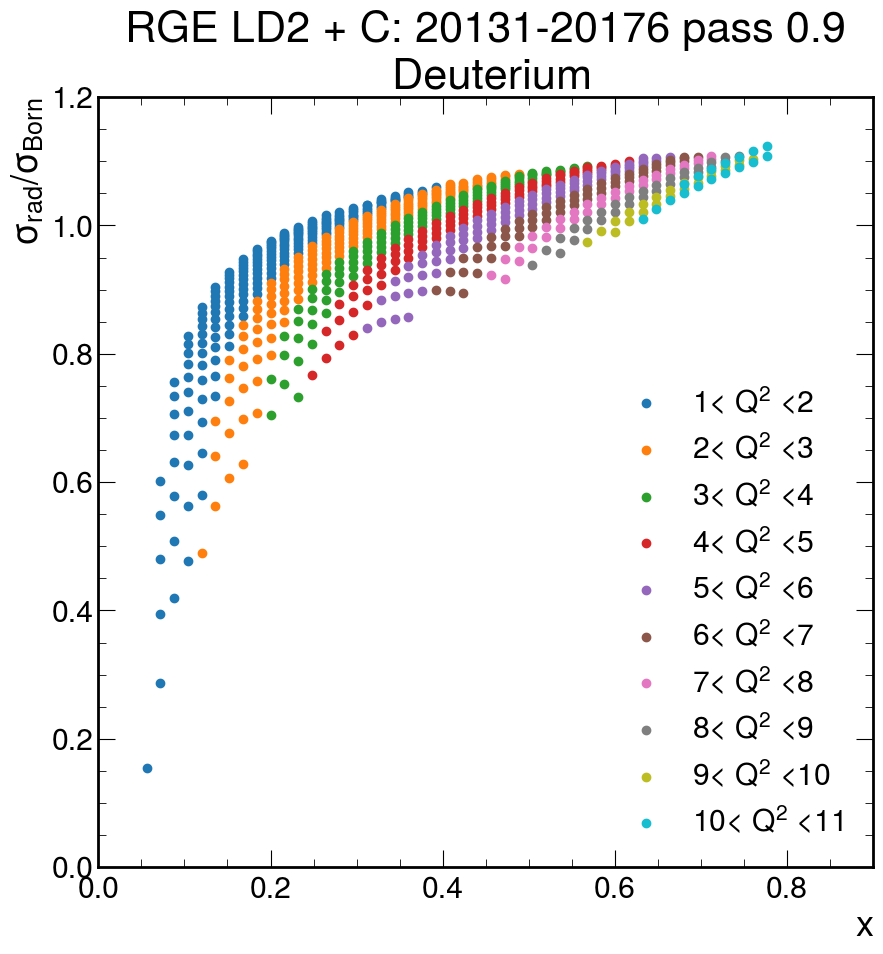

In [39]:
for i, Q2_lower_edge in enumerate(Q2_binning):
    if i == len(Q2_binning)-1:
        continue
    Q2_range = (Q2_lower_edge, Q2_binning[i+1])
    
    corrections = bin_dataframes["LD2"].query(f"Q2_bin_center>{Q2_range[0]} & Q2_bin_center<{Q2_range[1]} and nonnormalized_cross_sections>0 ")
    
    
    plt.scatter(corrections["x_bin_center"], corrections["Sig_Born"]/corrections["Sig_Rad"], label=f"{round(Q2_range[0],2)}< $Q^2$ <{round(Q2_range[1],2)}")
plt.legend()
plt.xlabel("x")
plt.ylabel("$\sigma_{rad}/\sigma_{Born}$")
plt.title(plot_title+"\n Deuterium")
plt.xlim(0, .9)
plt.ylim(0, 1.2)

Text(0.5, 1.0, 'RGE LD2 + C: 20131-20176 pass 0.9\n Deuterium')

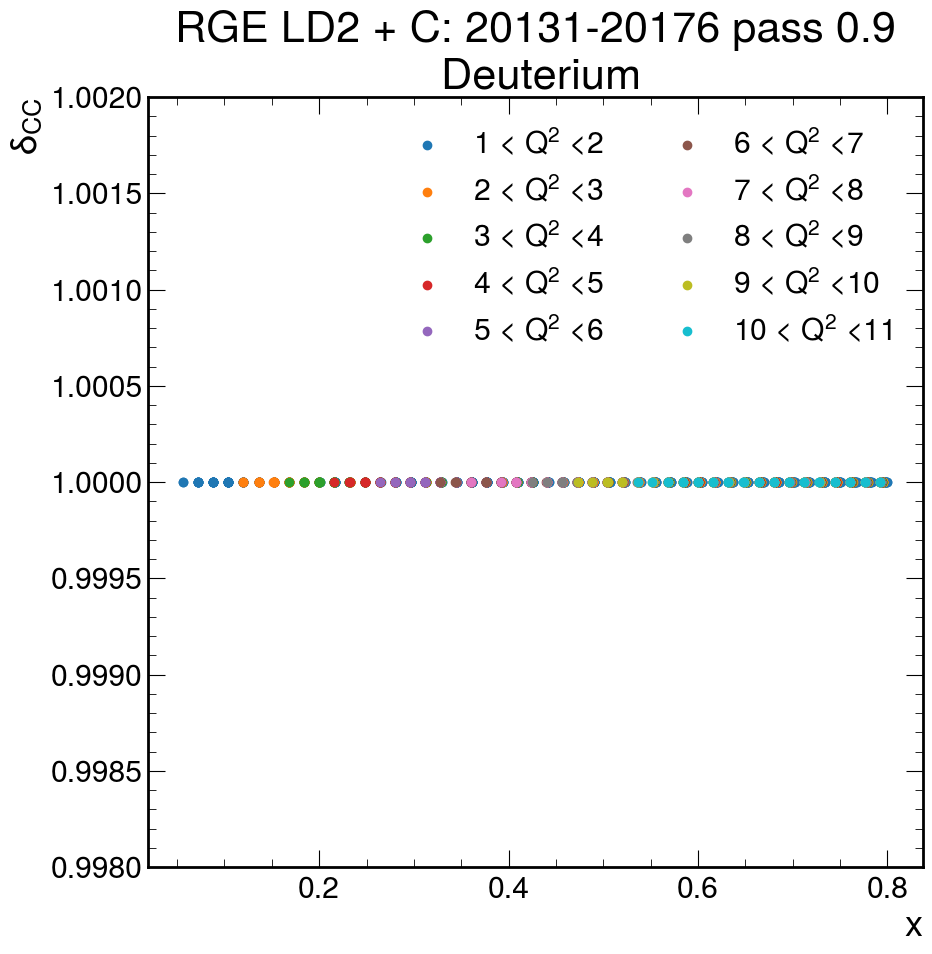

In [40]:
for i, Q2_lower_edge in enumerate(Q2_binning):
    if i == len(Q2_binning)-1:
        continue
    Q2_range = (Q2_lower_edge, Q2_binning[i+1])
    
    corrections = corrections_dict["LD2"].query(f"Q2>{Q2_range[0]} & Q2<{Q2_range[1]}") 
    plt.scatter(corrections["x"], corrections["C_cor"], label=f"{round(Q2_range[0],2)} < $Q^2$ <{round(Q2_range[1],2)}")
plt.legend(ncol=2)
plt.xlabel("x")
plt.ylabel("$\delta_{CC}$")
plt.ylim(.998, 1.002)
plt.title(plot_title+"\n Deuterium")

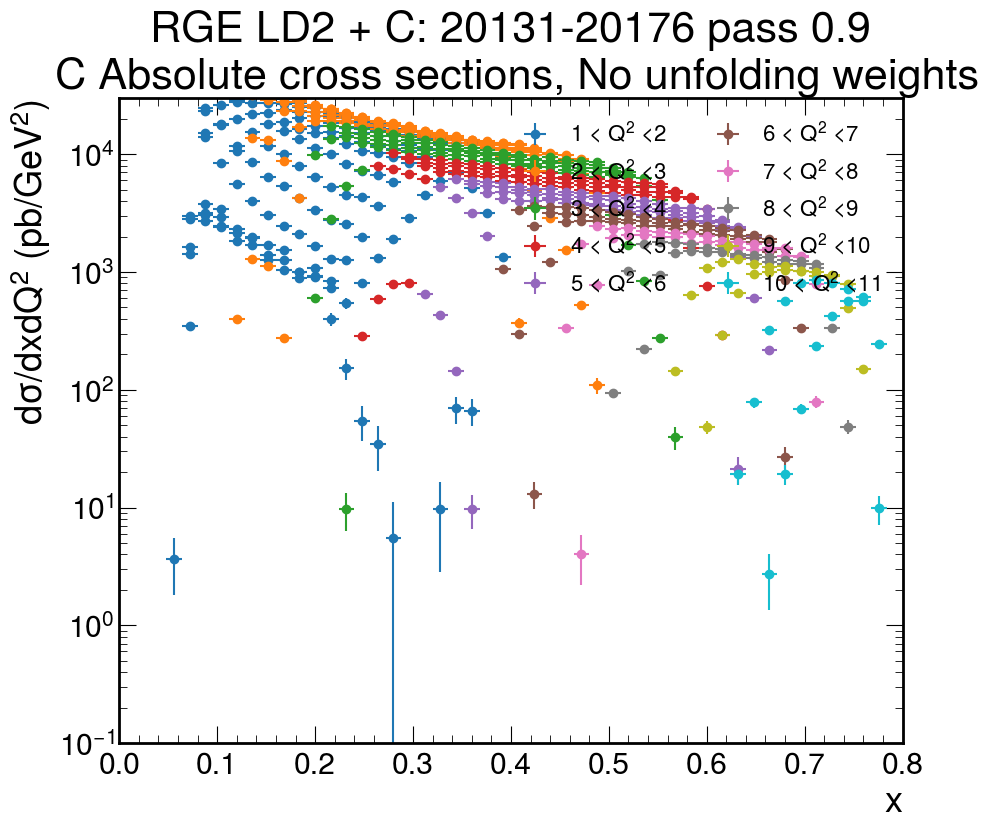

In [41]:
y_low, y_high = 0, 100
fig = plt.figure(figsize=(10,8))

for i, Q2_lower_edge in enumerate(Q2_binning):
    if i == len(Q2_binning)-1:
        continue
    Q2_range = (Q2_lower_edge, Q2_binning[i+1])

    masked_dataframe = bin_dataframes_nounfolding["C"].query(f"Q2_bin_center>{Q2_range[0]} & Q2_bin_center<{Q2_range[1]} and absolute_cross_sections>0")

    bin_widths = x_bin_centers[1] - x_bin_centers[0]

    plot = plt.errorbar(
        masked_dataframe["x_bin_center"],
        masked_dataframe["absolute_cross_sections"],
        xerr = bin_widths/2,
        yerr = masked_dataframe["absolute_cross_sections_errors"],
        label=f"{round(Q2_range[0],2)} < $Q^2$ <{round(Q2_range[1],2)}",
        fmt="o",
    )

plt.xlabel("x")
plt.ylabel(f"$d \sigma/dxdQ^2~ (pb/GeV^{2})$")
plt.legend(ncol=2, loc='upper right', fontsize=16)
plt.tight_layout()
plt.ylim(10**-1,3*10**4)
plt.xlim(0,.8)
plt.title(plot_title+"\n C Absolute cross sections, No unfolding weights")
plt.yscale('log')

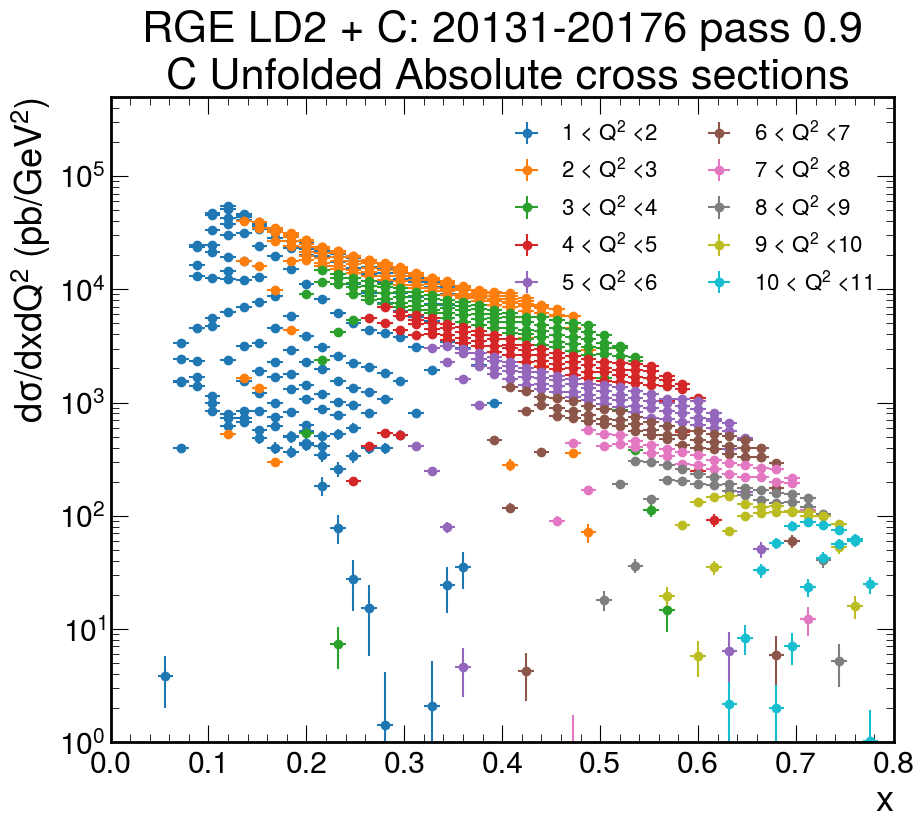

In [42]:
y_low, y_high = 0, 100
fig = plt.figure(figsize=(10,8))

for i, Q2_lower_edge in enumerate(Q2_binning):
    if i == len(Q2_binning)-1:
        continue
    Q2_range = (Q2_lower_edge, Q2_binning[i+1])

    masked_dataframe = bin_dataframes["C"].query(f"Q2_bin_center>{Q2_range[0]} & Q2_bin_center<{Q2_range[1]} and absolute_cross_sections>0")

    bin_widths = x_bin_centers[1] - x_bin_centers[0]

    plot = plt.errorbar(
        masked_dataframe["x_bin_center"],
        masked_dataframe["absolute_cross_sections"],
        xerr = bin_widths/2,
        yerr = masked_dataframe["absolute_cross_sections_errors"],
        label=f"{round(Q2_range[0],2)} < $Q^2$ <{round(Q2_range[1],2)}",
        fmt="o",
    )

plt.xlabel("x")
plt.ylabel(f"$d \sigma/dxdQ^2~ (pb/GeV^{2})$")
plt.legend(ncol=2, loc='upper right', fontsize=16)
plt.tight_layout()
plt.ylim(10**0,5*10**5)
plt.xlim(0,.8)
plt.title(plot_title+"\n C Unfolded Absolute cross sections")
plt.yscale('log')

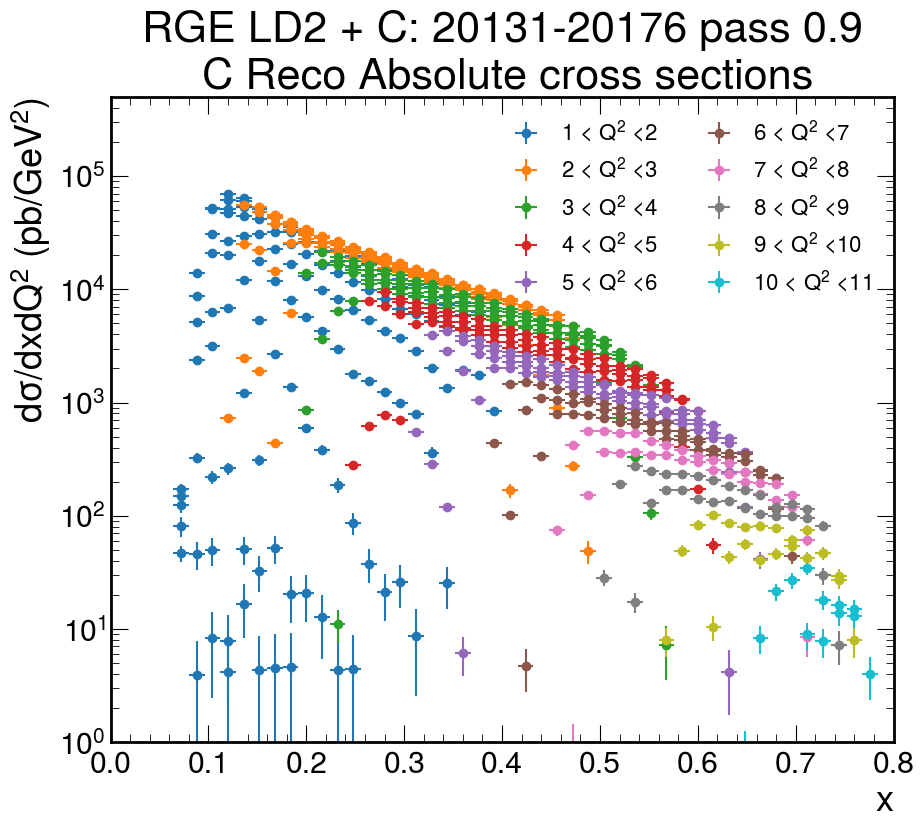

In [43]:
y_low, y_high = 0, 100
fig = plt.figure(figsize=(10,8))

for i, Q2_lower_edge in enumerate(Q2_binning):
    if i == len(Q2_binning)-1:
        continue
    Q2_range = (Q2_lower_edge, Q2_binning[i+1])

    masked_dataframe = bin_dataframes_reco["C"].query(f"Q2_bin_center>{Q2_range[0]} & Q2_bin_center<{Q2_range[1]} and absolute_cross_sections>0")

    bin_widths = x_bin_centers[1] - x_bin_centers[0]

    plot = plt.errorbar(
        masked_dataframe["x_bin_center"],
        masked_dataframe["absolute_cross_sections"],
        xerr = bin_widths/2,
        yerr = masked_dataframe["absolute_cross_sections_errors"],
        label=f"{round(Q2_range[0],2)} < $Q^2$ <{round(Q2_range[1],2)}",
        fmt="o",
    )

plt.xlabel("x")
plt.ylabel(f"$d \sigma/dxdQ^2~ (pb/GeV^{2})$")
plt.legend(ncol=2, loc='upper right', fontsize=16)
plt.tight_layout()
plt.ylim(10**-0,5*10**5)
plt.xlim(0,.8)
plt.title(plot_title+"\n C Reco Absolute cross sections")
plt.yscale('log')

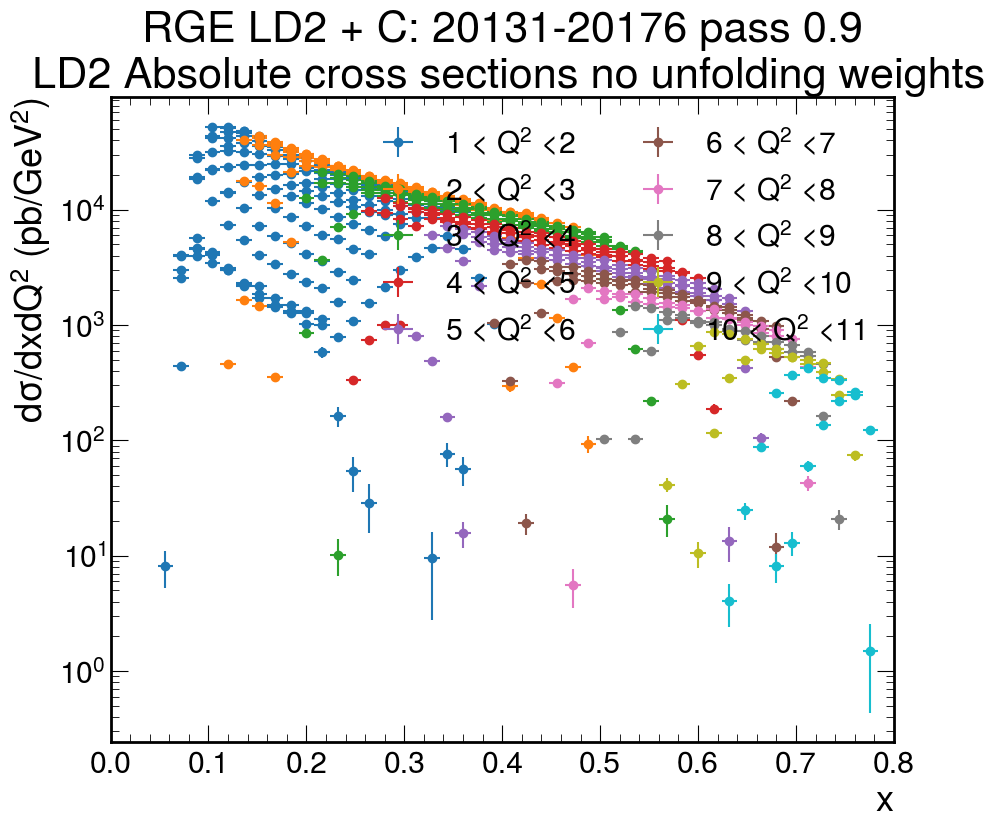

In [44]:
y_low, y_high = 0, 100
fig = plt.figure(figsize=(10,8))

for i, Q2_lower_edge in enumerate(Q2_binning):
    if i == len(Q2_binning)-1:
        continue
    Q2_range = (Q2_lower_edge, Q2_binning[i+1])

    masked_dataframe = bin_dataframes_nounfolding["LD2"].query(f"Q2_bin_center>{Q2_range[0]} & Q2_bin_center<{Q2_range[1]} and absolute_cross_sections>0")

    bin_widths = x_bin_centers[1] - x_bin_centers[0]

    plot = plt.errorbar(
        masked_dataframe["x_bin_center"],
        masked_dataframe["absolute_cross_sections"],
        xerr = bin_widths/2,
        yerr = masked_dataframe["absolute_cross_sections_errors"],
        label=f"{round(Q2_range[0],2)} < $Q^2$ <{round(Q2_range[1],2)}",
        fmt="o",
    )

plt.xlabel("x")
plt.ylabel(f"$d \sigma/dxdQ^2~ (pb/GeV^{2})$")
plt.legend(ncol=2, loc='upper right')
plt.tight_layout()
plt.xlim(0,.8)
plt.title(plot_title+"\n LD2 Absolute cross sections no unfolding weights")
plt.yscale('log')

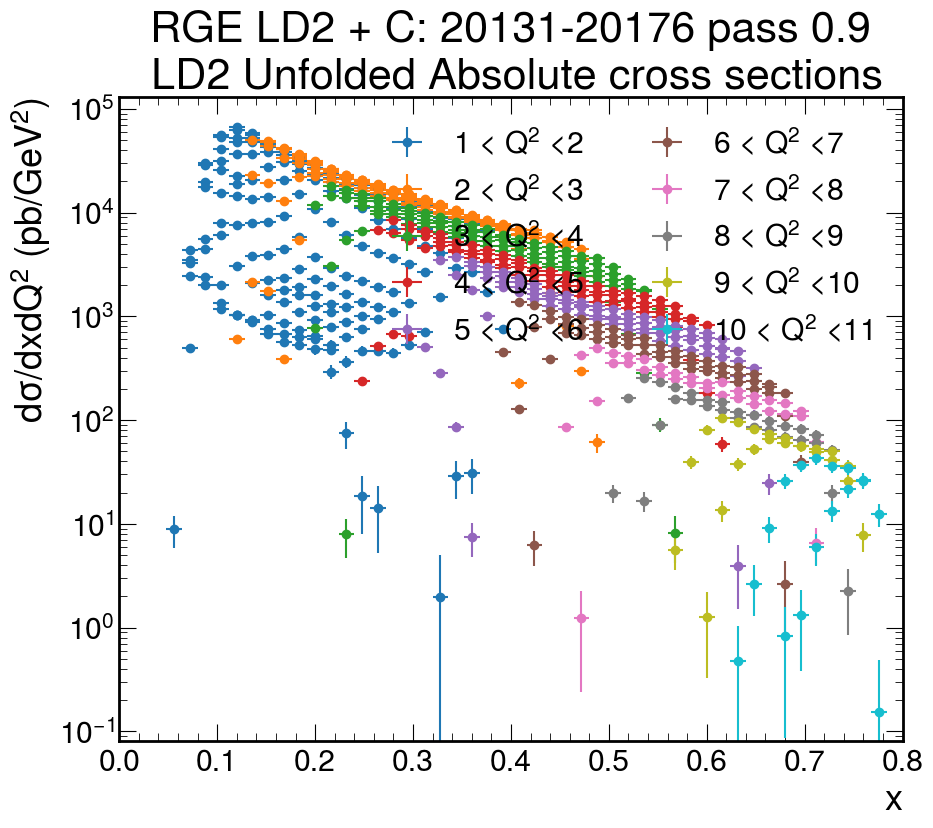

In [45]:
y_low, y_high = 0, 100
fig = plt.figure(figsize=(10,8))

for i, Q2_lower_edge in enumerate(Q2_binning):
    if i == len(Q2_binning)-1:
        continue
    Q2_range = (Q2_lower_edge, Q2_binning[i+1])

    masked_dataframe = bin_dataframes["LD2"].query(f"Q2_bin_center>{Q2_range[0]} & Q2_bin_center<{Q2_range[1]} and absolute_cross_sections>0")

    bin_widths = x_bin_centers[1] - x_bin_centers[0]

    plot = plt.errorbar(
        masked_dataframe["x_bin_center"],
        masked_dataframe["absolute_cross_sections"],
        xerr = bin_widths/2,
        yerr = masked_dataframe["absolute_cross_sections_errors"],
        label=f"{round(Q2_range[0],2)} < $Q^2$ <{round(Q2_range[1],2)}",
        fmt="o",
    )

plt.xlabel("x")
plt.ylabel(f"$d \sigma/dxdQ^2~ (pb/GeV^{2})$")
plt.legend(ncol=2, loc='upper right')
plt.tight_layout()
plt.xlim(0,.8)
plt.title(plot_title+"\n LD2 Unfolded Absolute cross sections")
plt.yscale('log')

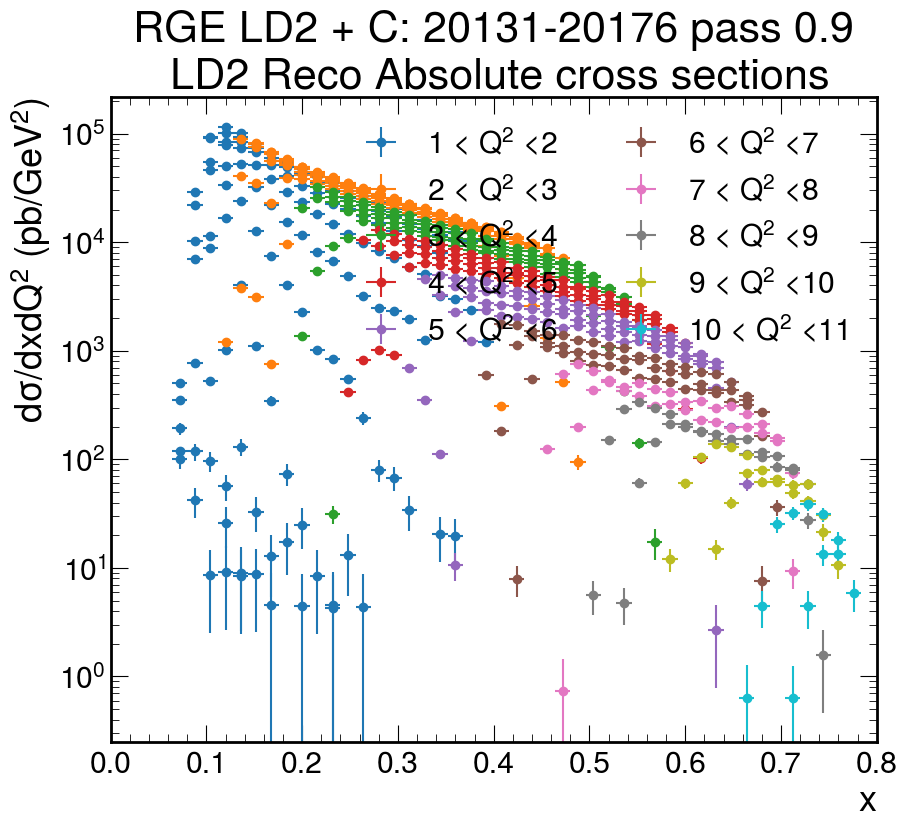

In [46]:
y_low, y_high = 0, 100
fig = plt.figure(figsize=(10,8))

for i, Q2_lower_edge in enumerate(Q2_binning):
    if i == len(Q2_binning)-1:
        continue
    Q2_range = (Q2_lower_edge, Q2_binning[i+1])

    masked_dataframe = bin_dataframes_reco["LD2"].query(f"Q2_bin_center>{Q2_range[0]} & Q2_bin_center<{Q2_range[1]} and absolute_cross_sections>0")

    bin_widths = x_bin_centers[1] - x_bin_centers[0]

    plot = plt.errorbar(
        masked_dataframe["x_bin_center"],
        masked_dataframe["absolute_cross_sections"],
        xerr = bin_widths/2,
        yerr = masked_dataframe["absolute_cross_sections_errors"],
        label=f"{round(Q2_range[0],2)} < $Q^2$ <{round(Q2_range[1],2)}",
        fmt="o",
    )

plt.xlabel("x")
plt.ylabel(f"$d \sigma/dxdQ^2~ (pb/GeV^{2})$")
plt.legend(ncol=2, loc='upper right')
plt.tight_layout()
plt.xlim(0,.8)
plt.title(plot_title+"\n LD2 Reco Absolute cross sections")
plt.yscale('log')

In [47]:
print(np.unique(bin_dataframes_reco["C"]["Q2_bin_center"]))
print(bin_dataframes_reco["C"]["x_bin_center"][(bin_dataframes_reco["C"]["Q2_bin_center"]>3) & (bin_dataframes_reco["C"]["Q2_bin_center"]<3.2)])

[ 1.02736592  1.08359556  1.14290275  1.20545592  1.27143275  1.34102062
  1.41441715  1.49183082  1.57348147  1.65960102  1.75043405  1.84623854
  1.94728659  2.05386518  2.16627702  2.28484136  2.40989495  2.54179295
  2.68090998  2.82764113  2.98240316  3.14563559  3.31780204  3.49939147
  3.69091963  3.89293048  4.10599776  4.3307266   4.56775527  4.81775696
  5.0814417   5.35955839  5.65289692  5.96229041  6.28861758  6.63280524
  6.99583092  7.37872567  7.78257696  8.20853178  8.65779989  9.13165727
  9.63144974 10.15859678 10.71459555]
21      0.008
66      0.024
111     0.040
156     0.056
201     0.072
246     0.088
291     0.104
336     0.120
381     0.136
426     0.152
471     0.168
516     0.184
561     0.200
606     0.216
651     0.232
696     0.248
741     0.264
786     0.280
831     0.296
876     0.312
921     0.328
966     0.344
1011    0.360
1056    0.376
1101    0.392
1146    0.408
1191    0.424
1236    0.440
1281    0.456
1326    0.472
1371    0.488
1416    0.504
146

In [48]:
cols = [
    "x_bin_center",
    "Q2_bin_center",
    "absolute_cross_sections",
    "absolute_cross_sections_errors",
]

fmt = "%.6e"   # or "%.6f" if you prefer fixed-point

bin_dataframes["C"][cols] \
    .query("absolute_cross_sections > 0") \
    .to_csv(
        "unfolded_carbon_absolute_cross_sections_pass09.csv",
        index=False,
    )

bin_dataframes["LD2"][cols] \
    .query("absolute_cross_sections > 0") \
    .to_csv(
        "unfolded_deuterium_absolute_cross_sections_pass09.csv",
        index=False,
    )

bin_dataframes_reco["C"][cols] \
    .query("absolute_cross_sections > 0") \
    .to_csv(
        "reco_carbon_absolute_cross_sections_pass09.csv",
        index=False,
    )

bin_dataframes_reco["LD2"][cols] \
    .query("absolute_cross_sections > 0") \
    .to_csv(
        "reco_deuterium_absolute_cross_sections_pass09.csv",
        index=False,
    )
